 # Developing a system for categorizing movie reviews 

'Junky Union', a community for classic movie lovers, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to detect negative reviews automatically.

## Contents <a id='back'></a>

* [Intro](#intro)
* [Stage 1. Data loading and preprocessing](#1)
    * [1.1 Data exploration](#1.1)
* [Stage 2. Evaluation procedure](#2)
* [Stage 3. Normalization](#3)
* [Stage 4. Train / Test split](#4)
* [Stage 5. Working with models](#5)
    * [5.1 Model 0 - Constant](#5.1)
    * [5.2 Model 1 - NLTK, TF-IDF and LR](#5.2)
    * [5.3 Model 2 - NLTK, TF-IDF and LGBMClassifier](#5.3)
    * [5.4 Model 3 - spaCy, TF-IDF and LR](#5.4)
    * [5.5 Model 4 - spaCy, TF-IDF and LGBMClassifier](#5.5)
    * [5.6 Model 5 - BERT LR](#5.6)
    * [5.7 Model 6 - BERT LGBMClassifier](#5.7)
* [Stage 6. Models quality](#6)
    * [6.1 Model 1](#6.1)
    * [6.2 Model 2](#6.2)
    * [6.3 Model 3](#6.3)
    * [6.4 Model 4](#6.4)
    * [6.5 Model 5](#6.5)
    * [6.6 Model 6](#6.6)
* [Stage 7. Models analysis](#7)
* [Conclusion](#8)

## Introduction <a id='intro'></a>

We will use a dataset of IMDb (Internet Movie Database) with polarity legends to build a model to classify positive and negative reviews. This must reach an F1 value of at least 0.85.

## Stage 1. Data loading and preprocessing <a id='1'></a>

In [69]:
# Loading all libraries
import math
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.sparse import csr_matrix

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)

import spacy
import torch
import transformers

from lightgbm import LGBMClassifier
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [38]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'  

# this helps having graphics of better quality
%config InlineBackend.figure_format = 'retina'

sns.set_style('darkgrid') 

In [39]:
# this is for using progress_apply
tqdm.pandas()

In [8]:
# Load the data files into DataFrame
df = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [9]:
df.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


### 1.1 Data exploration <a id='1.1'></a>

In [10]:
# printing the general/summary information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

'average_rating' and 'votes' are the only columns with null values. We can just drop those lines:

In [15]:
# remover NAN
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

The dataset contains the following relevant fields:
- `review` — the text of the review
- `pos` — the target, '0' for negative and '1' for positive
- `ds_part` — training'/'test' for the training/testing part of the data set

In [16]:
df.duplicated().sum()

0

In [40]:
# calling the describe method with round(3)
df.describe().round(3)

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47329.000,47329.000,47329.000,47329.0,47329.000,47329.000,47329.000
mean,1989.631,0.002,5.998,25562.917,5.484,0.499,6279.827
std,19.601,0.042,1.494,83670.039,3.473,0.500,3605.724
min,1894.000,0.000,1.400,9.0,1.000,0.000,0.000
25%,1982.000,0.000,5.100,827.0,2.000,0.000,3162.000
50%,1998.000,0.000,6.300,3197.0,4.000,0.000,6300.000
75%,2004.000,0.000,7.100,13974.0,9.000,1.000,9412.000
max,2010.000,1.000,9.700,1739448.0,10.000,1.000,12499.000


It's weird but the first movie was in 1894 while the last is in 2010. Mean 'average_rating' is ~6

Let's look at the number of movies and reviews over the years:

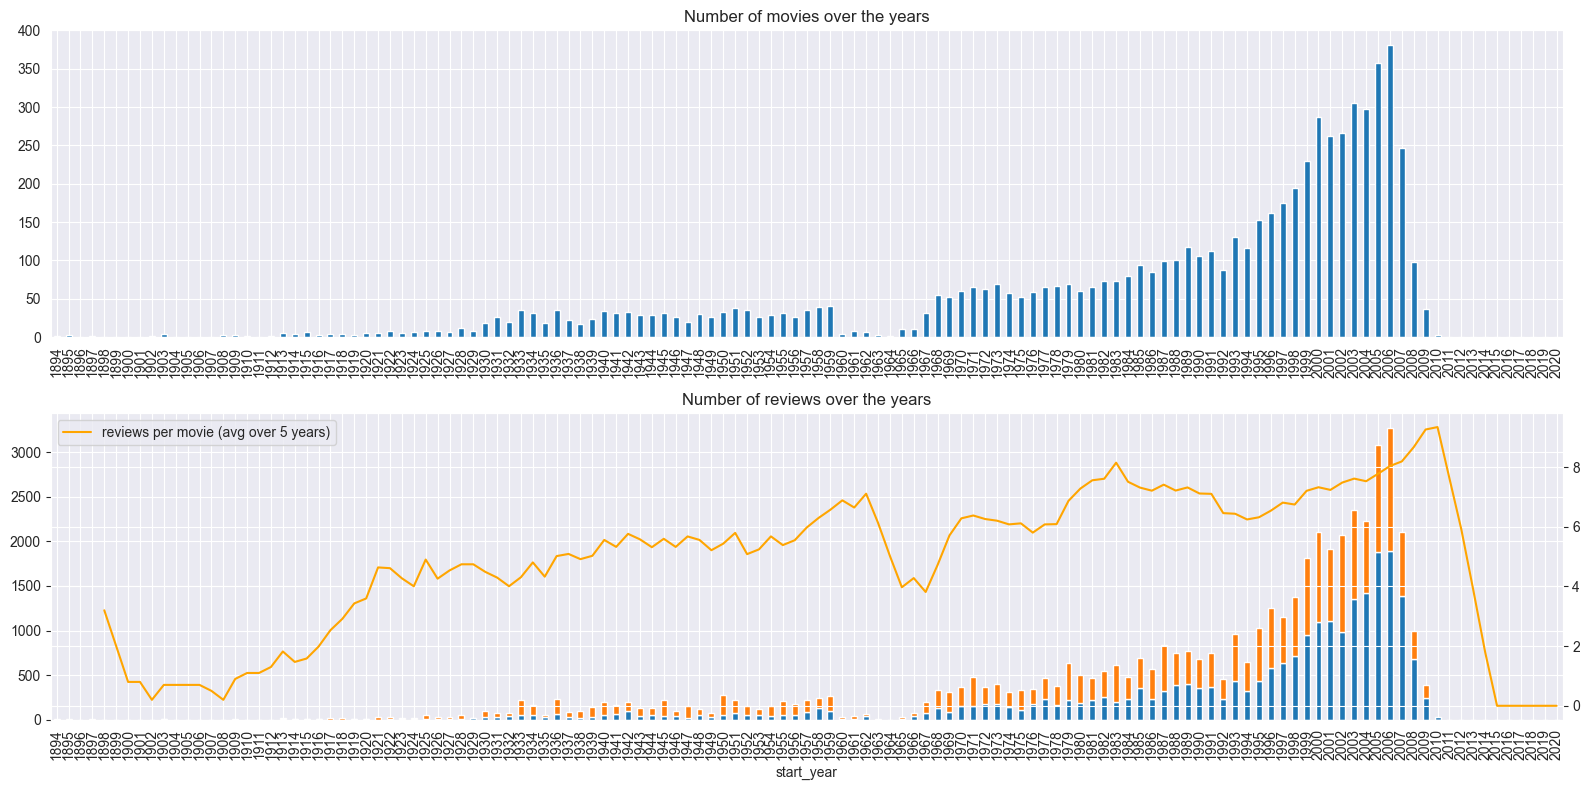

In [17]:
# set the number of rows and columns, as well as the size of subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Axis 0 - Graph for the first row
ax = axs[0]

# get the count of unique values for each year and plot a bar chart.
dft1 = df[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of movies over the years')

# Axis 0 - Graph for the second row
ax = axs[1]

# grouping by year and pos, then get the number of positive and negative reviews in each year.
dft2 = df.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

# plot a bar graph
dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

# get the number of reviews per year
dft2 = df['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

# get the number of reviews a movie receive each year
# plot a line graph for the number of reviews per movie every five years
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

# set a legend that indicates the content of the second graph
lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
ax.set_title('Number of reviews over the years')

fig.tight_layout()

So, the number of movies increased over the period 1930 - 2006. After that, there was a drop. Last year recorded is 2010. About the number of reviews per year, the trend is similar (in shape) to the graphic above. We can also say that the proportion of positive reviews (blue ones) is increasing over the years.

Let's look at the distribution of the number of reviews per movie with the exact count and KDE (Kernel Density Estimation), just to know how it can differ from the exact count.

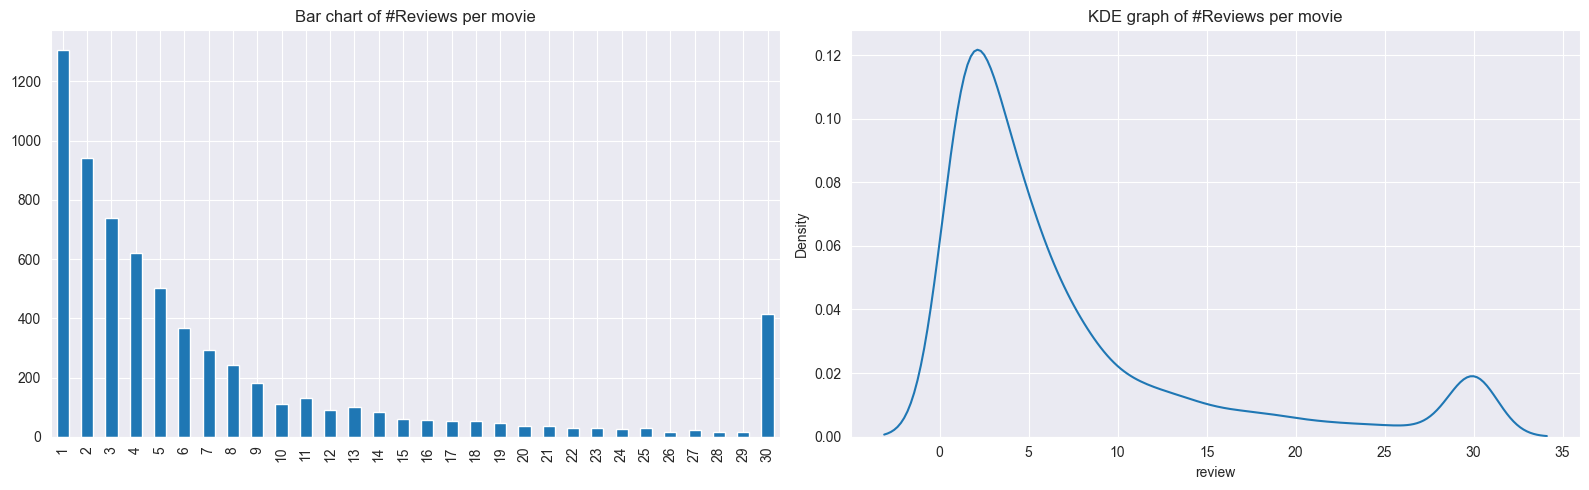

In [18]:
# set the number of rows and columns, as well as the size of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Axis 0 - Graph 1
ax = axs[0]

# grouping by the code of each movie 'tconst' and get the number of reviews of each one
# get the unique value count of the number of reviews, how many movies received a given number of reviews
# plot a bar graph
dft = df.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar chart of #Reviews per movie')

# Axis 1 - Graph 2
ax = axs[1]

# grouping by the code of each movie 'tconst' and obtain the number of reviews of each one
# plot a density distribution graph
dft = df.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE graph of #Reviews per movie')

fig.tight_layout()

So, the graphic on the left say that more than 1200 movies got just one review, less than 1000 movies got only 2 reviews and so on. For the density distribution graph there is a similar pattern, with the highest frequency density of around 0.12 being observed between 0 to 5 reviews and then a weird peak occurring around 30 reviews.

Let's quickly analyze the number of positive and negative reviews and establish if there is a class imbalance.

In [19]:
df['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

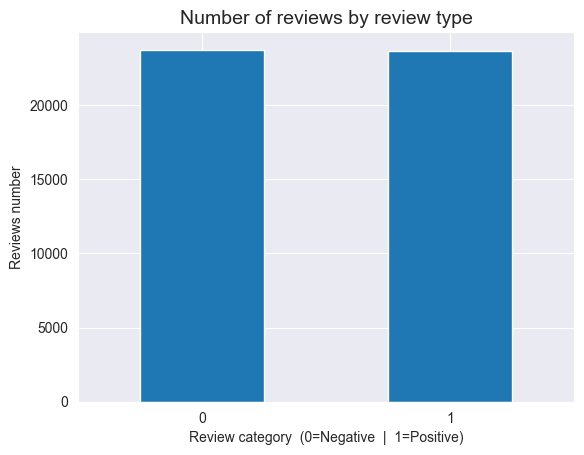

0    23715
1    23614
Name: pos, dtype: int64


In [27]:
df['pos'].value_counts().plot(kind='bar', xlabel='Review category  (0=Negative  |  1=Positive)', ylabel='Reviews number',rot= 360)
plt.title('Number of reviews by review type', fontsize=14)
plt.show()
print(df['pos'].value_counts())

It seems no class imbalance occurs. No need to upsample or downsample part of the dataframe.

Let's analyze more in detail if there is a class imbalance looking at the distribution of positive and negative classes in the training and test set.

In [37]:
df_train =  df.query('ds_part == "train"')
df_test =  df.query('ds_part == "test"')
pos_train = df_train['pos'].value_counts(normalize=True)
pos_test = df_test['pos'].value_counts(normalize=True)

print('Training set, ratio of negative to positive reviews:')
print(pos_train)

print()
print('Test set, ratio of negative to positive reviews:')
print(pos_test)

Training set, ratio of negative to positive reviews:
0    0.500588
1    0.499412
Name: pos, dtype: float64

Test set, ratio of negative to positive reviews:
0    0.501551
1    0.498449
Name: pos, dtype: float64


In this case too, everything is well balanced. This is good for training!

Let's now analyze the distribution of films by ratings in each data set:

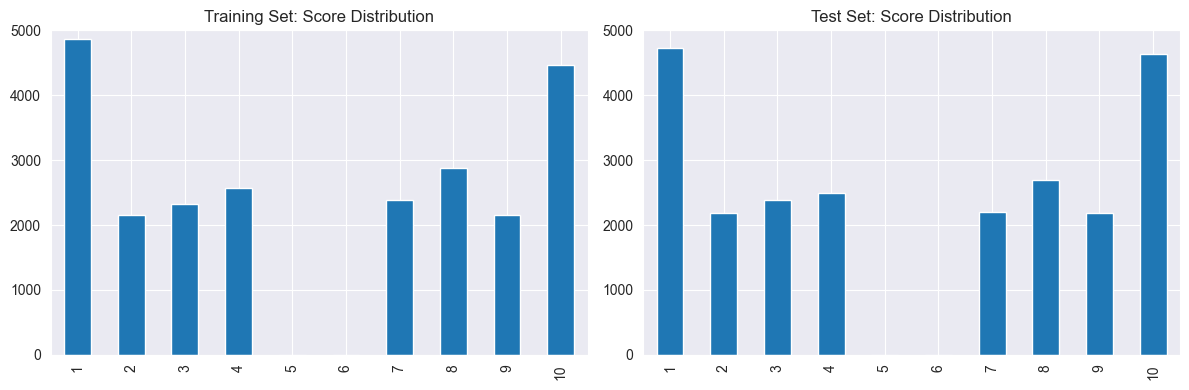

In [20]:
# set the number of rows and columns, as well as the size of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# first graph
ax = axs[0]

# filtering the dataset by the training set and obtain unique values by 'rating'
# plot a bar graph
dft = df.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Training Set: Score Distribution')

# second graph
ax = axs[1]

# filtering the dataset by the test set and obtain unique values by 'rating'
# plot a bar graph
dft = df.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test Set: Score Distribution')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the data set:

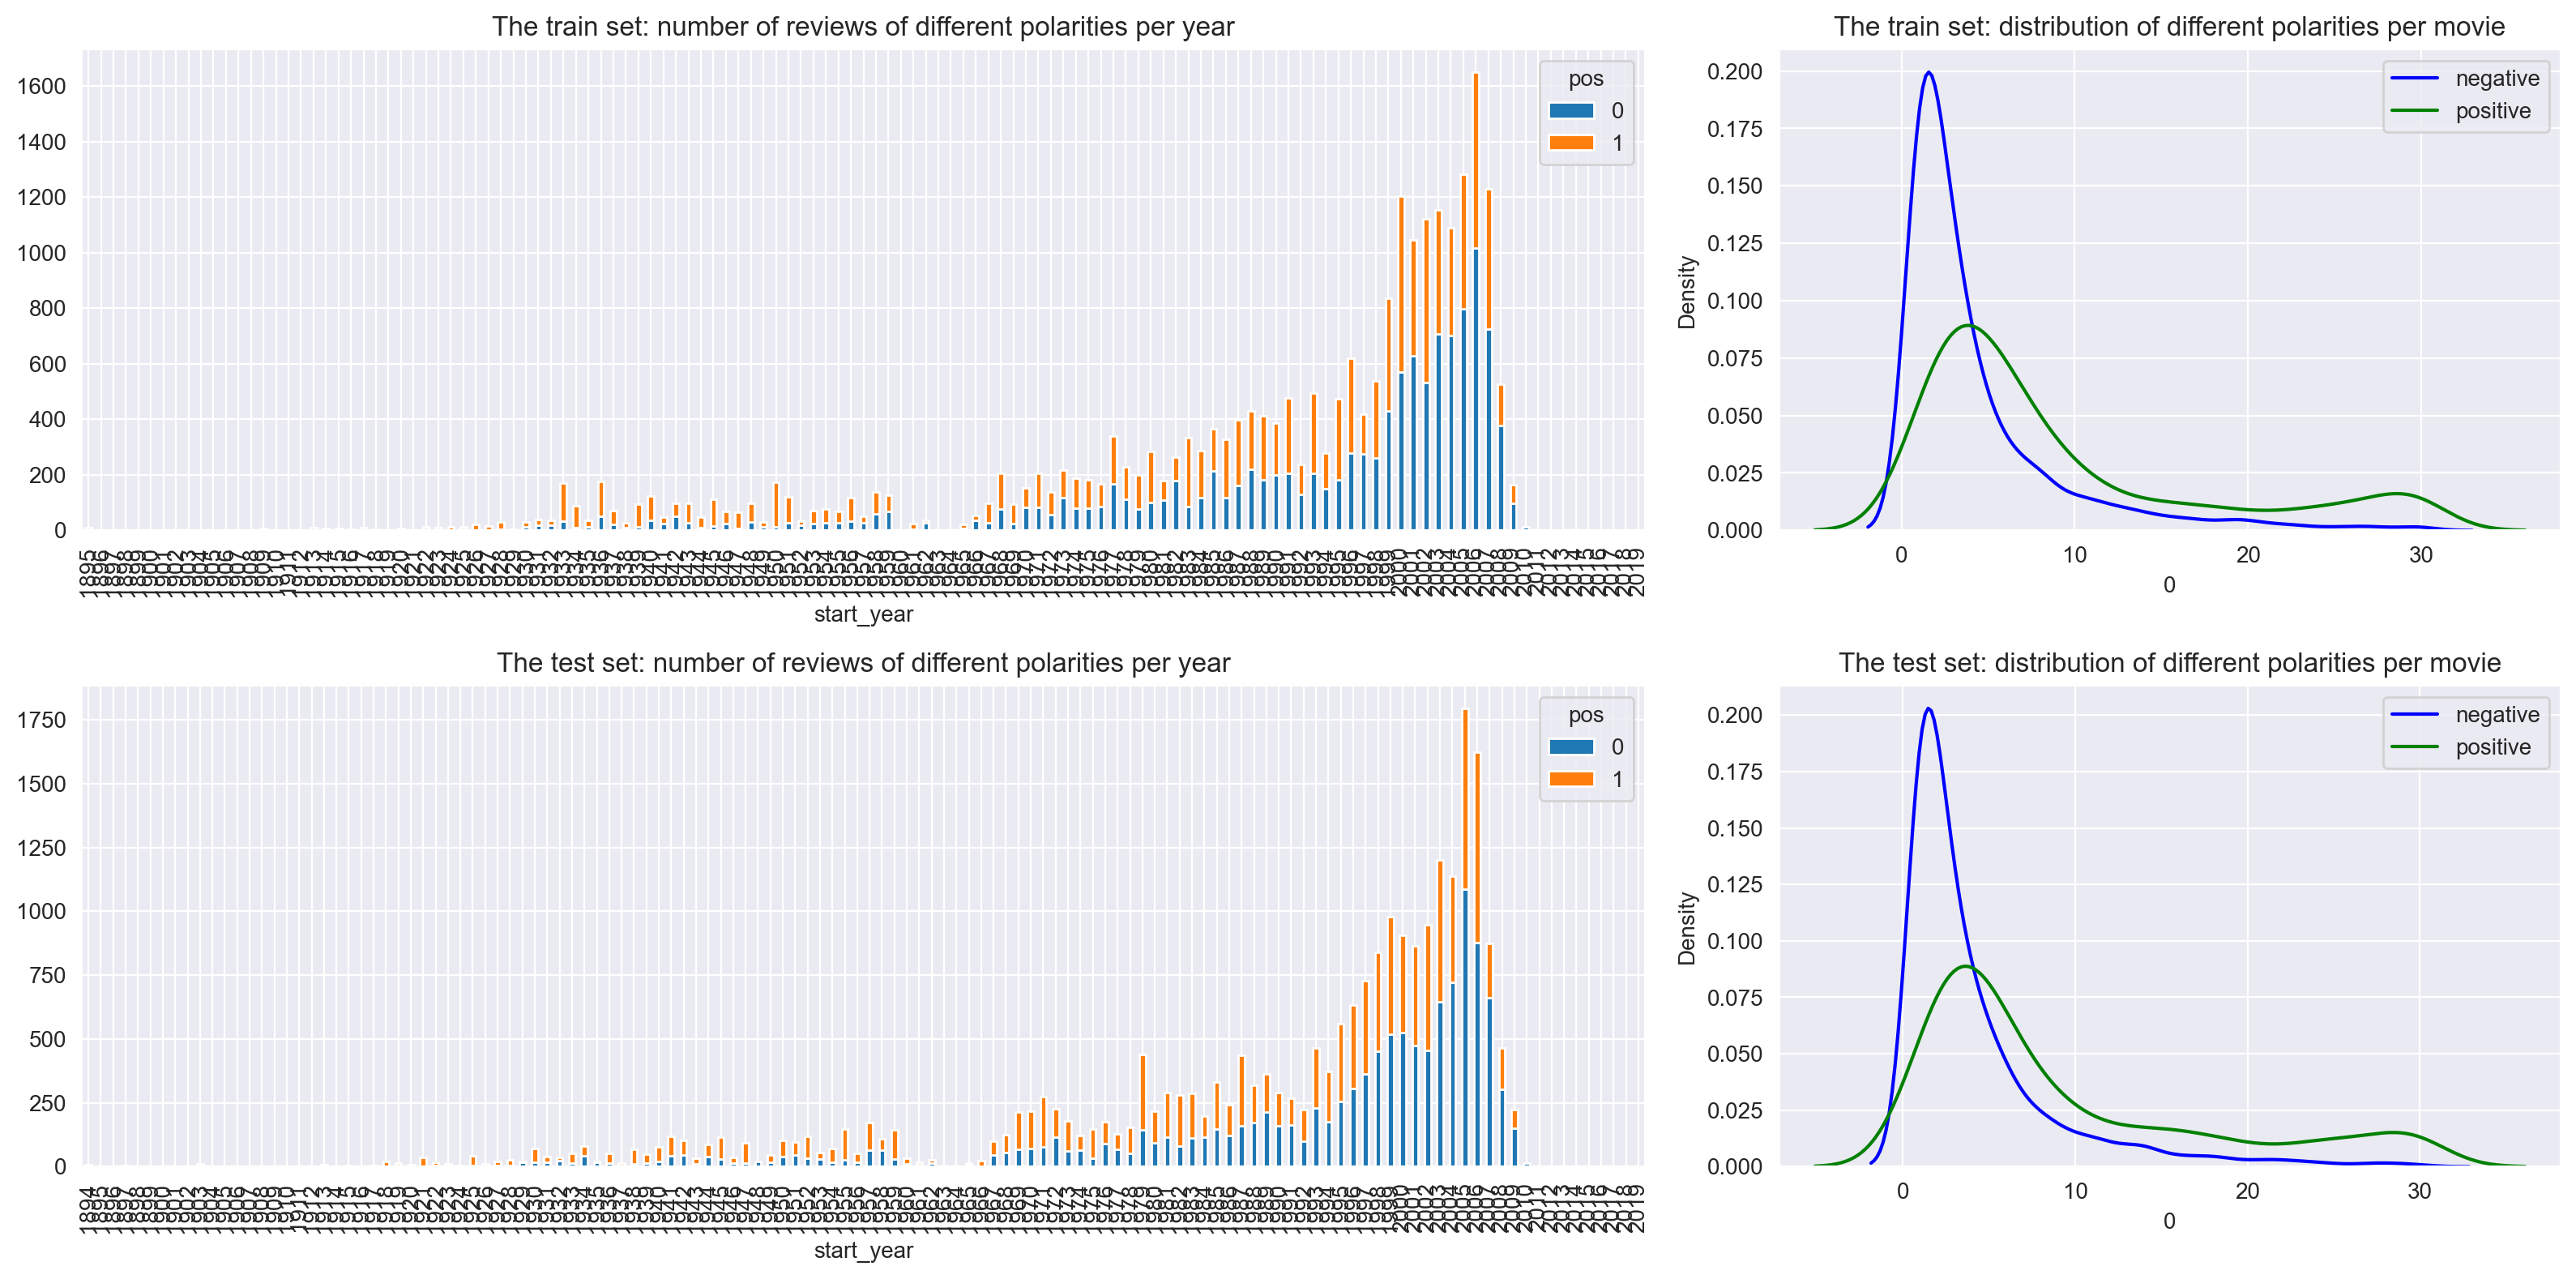

In [41]:
# set the number of rows and columns, as well as the size of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Graph 0,0 axis - 1st row, 1st column
ax = axs[0][0]

# filtering the dataset with training data, group by 'start_year' and 'pos'
# converting the index to an integer type
# plot a bar chart of the number of reviews by year and review polarity 'pos'
dft = df.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: number of reviews of different polarities per year')

# Graph 0,0 axis - 1st row, 2nd column
ax = axs[0][1]

# filtering the dataset with training data, group by identifier 'tconst' and 'pos'
# get the number of positive and negative reviews for each movie
# plot a distribution graph of densities by positive and negative reviews
dft = df.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Train set: distribution of different polarities per movie')

# Graph 1,0 axis - 2nd row, 1st column
ax = axs[1][0]

# filtering the dataset with test data, group by 'start_year' and 'pos'
# converting the index to an integer type
# plot a bar chart of the number of reviews by year and review polarity 'pos'
dft = df.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: number of reviews of different polarities per year')

# Graph 1,1 axis - 2nd row, 2nd column
ax = axs[1][1]

# filtering the dataset with test data, group by identifier 'tconst' and 'pos'
# get the number of positive and negative reviews for each movie
# plot a distribution graph of densities by positive and negative reviews
dft = df.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Test set: distribution of different polarities per movie')

fig.tight_layout()

So generally speaking, there is an increase in the number of reviews and there is also an increase of negative reviews. About the polarity, the two graphs are pretty similar. Those films that got between 0 and 5 reviews, show a bigger proportion of negative reviews, while for movies that got more reviews have more positive reviews than negative.

## Stage 2. Evaluation procedure <a id='2'></a>

In order to evaluate the performance of machine learning models for text, we will use the F1 value as a measurement metric, selecting the model that reaches an F1 of at least 0.85. We will build the 'evaluate_model' function that will allow us to compose an evaluation routine that can be used for all the models in this project.

In [57]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    '''
     this function returns the values for accuracy, average precision, F1 score, and ROC-AUC.
     It also returns ROC-AUC, F1 and PRC (precision-recall curve) curve plots
    
     :model: model pretrained and with hyperparameter tuning
     :train_features: training features
     :train_target_ test features
     :test_features: training target
     :test_target: test target
    
    '''    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 value
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # set some thresholds        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 value') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # set some thresholds         
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # set some thresholds       
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Stage 3. Normalization <a id='3'></a>

To build predictive models, we must assume that all models that will be trained only accept lowercase text, without digits, punctuation marks or additional spaces. So let's build the 'clear_text' function that will be applied in 'review' column and return the normalized text of each review.

In [44]:
def clear_text(text):
    
    '''
    Returns normalized text that includes only letters and apostrophes with no additional spaces.
    :text: text to be normalized.
    
    '''
    # set the text pattern to only letters, apostrophes, and spaces
    pattern = r"[^a-zA-Zñ']"
    
    # change characters that do not match the pattern with spaces
    text = re.sub(pattern, " ", text).lower()
    
    # get a list of words
    text_1 = text.split()
    
    # Recombine into a string with no extra spaces
    text_2 = " ".join(text_1)
    
    # Return lowercase text
    return text_2.lower()

# apply the 'clear_text' function to 'review' column
df['review_norm'] = df['review'].apply(clear_text)

Let's have a quick try of our 'clear_text' function:

In [53]:
# Comprobamos los cambios imprimiendo una crítica original y una crítica ya normalizada
print(df['review'][0])
print()
print(df['review_norm'][0])

The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (without introduction) in every other scene. The first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. There's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by Quincy Jones. There are a lot of parts that are laughably bad, too. Like, the bad guys chasing Beatty on thin ice with a CAR! Or, the police arriving at the scene roughly fifteen times. I really hated this movie!

the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that's not what i got out of it i didn't get anything in the first half there's a new character without introduction in every other scene the first half hour is completely incomprehensible 

## Stage 4. Train / Test split <a id='3'></a>

The entire data set is already divided into training/test parts; 'ds_part' is the related column. So, we now make two specific dataset: df_train and df_test

In [52]:
# split the dataset into a training and test set based on the variable 'ds_part'
df_train = df.query('ds_part == "train"').copy()
df_test = df.query('ds_part == "test"').copy()

# establish the objectives of each data set
train_target = df_train['pos']
test_target = df_test['pos']

# check the size of each set and the percentage by which the division has been performed.
print(f'df_train size: {df_train.shape}')
print(f'df_test size: {df_test.shape}')
print()
print(f'Percentage df_train: {len(df_train)/len(df)*100:.2f}%')
print(f'Percentage df_test: {len(df_test)/len(df)*100:.2f}%')

df_train size: (23796, 18)
df_test size: (23533, 18)

Percentage df_train: 50.28%
Percentage df_test: 49.72%


## Stage 5. Working with models <a id='5'></a>

Now that we have established our training and test set, let's continue with the training of machine learning models for text. Ee will use three pre-processing techniques: NLTK, spaCy and BERT. Then, we will apply them to different logistic regression models and gradient boosting, and finally we will evaluate the performance of each model through the F1 value with the evaluate_model function. The goal is F1 value >= 0.85.

### 5.1 Model 0 - Constant <a id='5.1'></a>

We start performing a sanity check. For this we will use a DummyClassifier model and we will pass the column 'review_norm' with the normalized reviews as feature. For the dummy model we will use the constant strategy that will always predict the positive class (1), considering that precision and sensitivity are based on the proportion of true positives.

In [54]:
# set the features of the training and testing set.
train_features_0 = df_train['review_norm']
test_features_0 = df_test['review_norm']

In [55]:
# calling DummyClassifier with strategy 'constant' and train it
model_dummy = DummyClassifier(strategy='constant', constant=1)
model_dummy.fit(train_features_0, train_target)

# review the distribution of predictions made by the model
predictions = model_dummy.predict(test_features_0)
predictions = pd.Series(predictions)
predictions.value_counts()

1    23533
dtype: int64

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


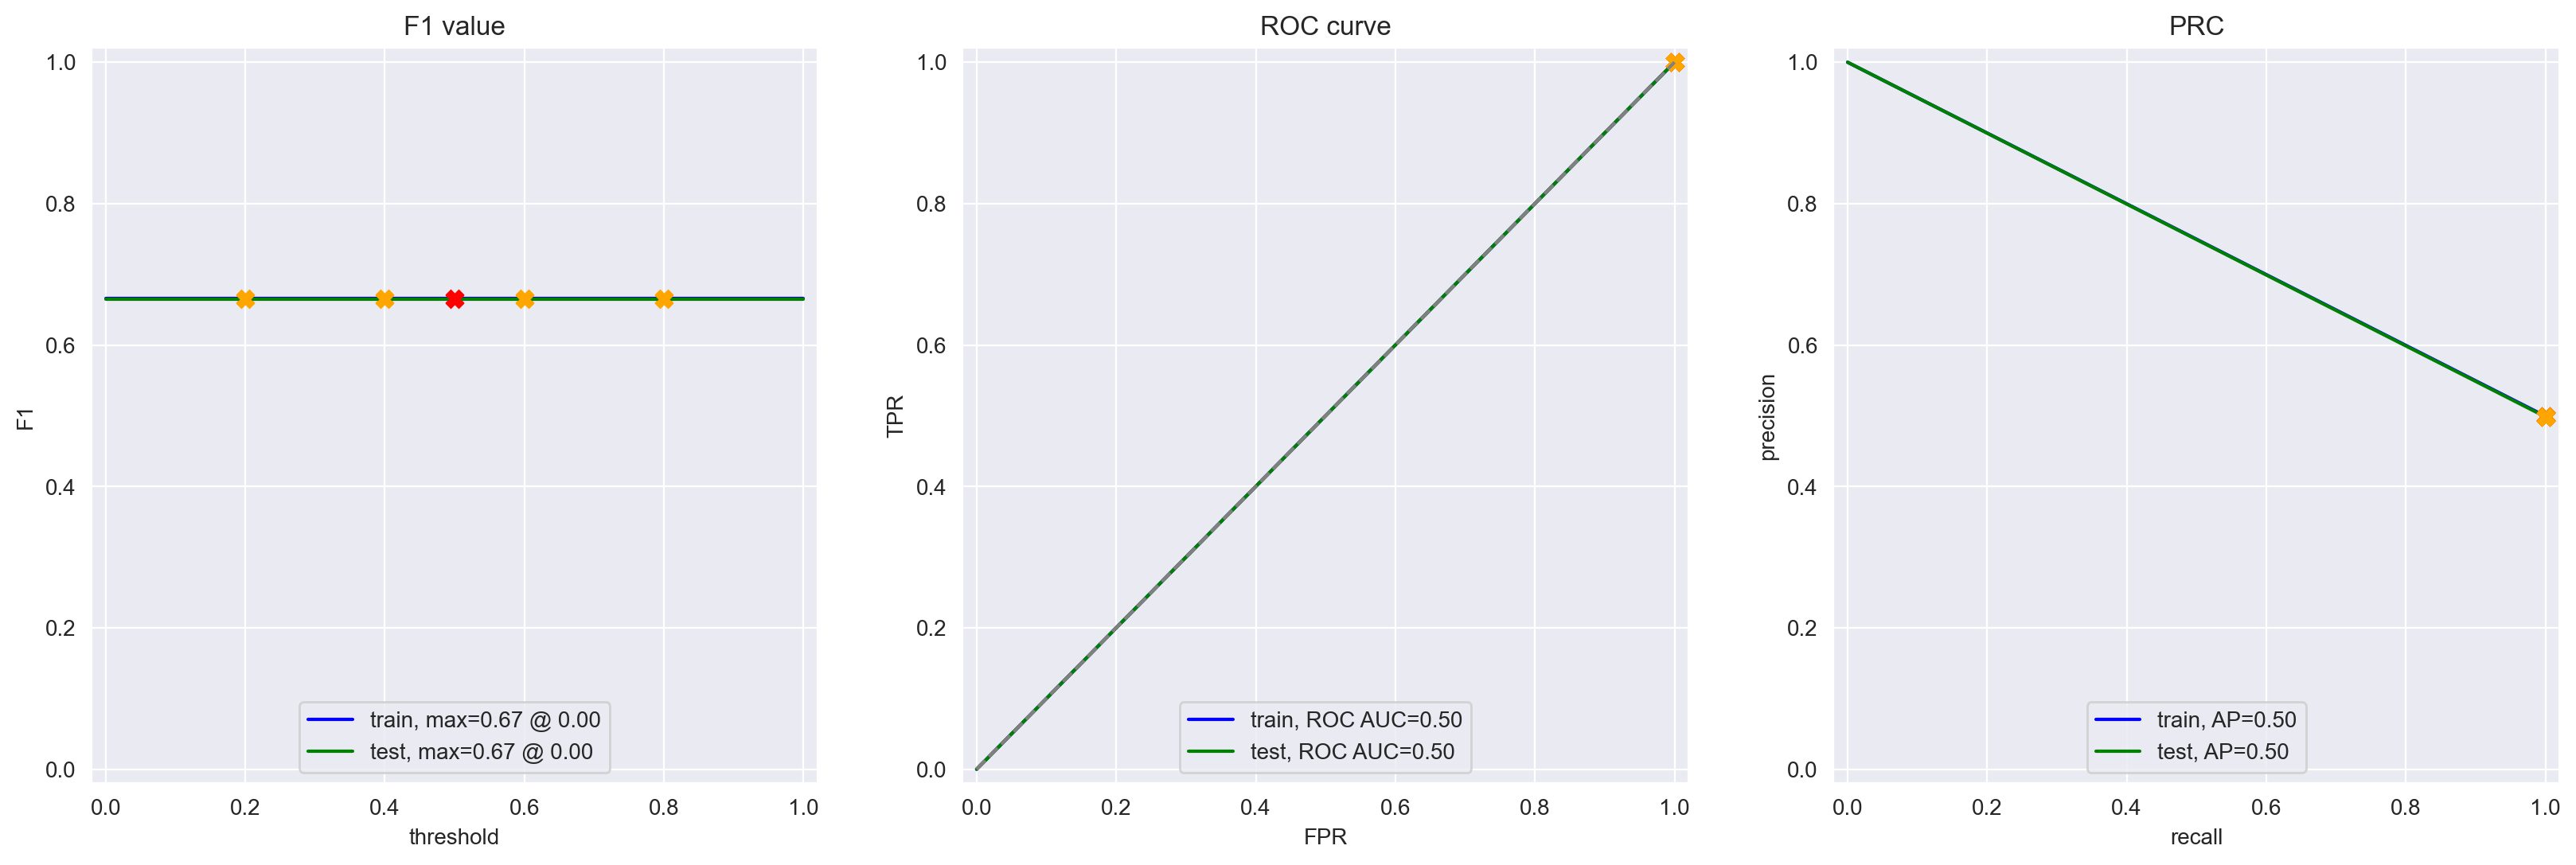

In [58]:
# evaluating the model by calling the function 'evaluate_model'
evaluate_model(model_dummy, train_features_0, train_target, test_features_0, test_target)

The graph on the left says that for a model to be considered better than a random one, it should have F1 > 0.67. At the same time the values of the accuracy, average precision and ROC-AUC metrics must be greater than 0.5.

### 5.2 Model 1 - NLTK, TF-IDF and LR <a id='5.2'></a>

Now we train our first model, which use the NLTK (Natural Language Toolkit) library to process text strings. A tokenization and lemmatization of each criticism will be done through the creation of the nltk_lemmatizer function and then the function will be applied to the normalized criticisms through apply.

##### TEXT PREPROCESSING WITH NLTK

In [60]:
def nltk_lemmatizer(text):
    
    '''
    Returns the tokenized and lemmatized text from the NLTK library.
    :text: text to be stemmed
    
    '''
    
    tokens = word_tokenize(text) # splitting the text into tokens
    lemmatizer = WordNetLemmatizer() # creating a lemmatized object
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] # getting lemmas of each token
    string_lemmas = " ".join(lemmas) # converting the list of processed lemmas into a line of text
    
    return string_lemmas 

Generating tokenized and lemmatized texts from the apply method tends to take a long time so we decide to generate them once, then save and load them via np.load.

In [61]:
# applying the 'nltk_lemmatizer' function to the training set
corpus_train_nltk = df_train['review_norm'].apply(nltk_lemmatizer)

# apply the 'nltk_lemmatizer' function to the test set
corpus_test_nltk = df_test['review_norm'].apply(nltk_lemmatizer)

In [63]:
# saving the lemmatized texts of both training and test set
np.savez_compressed('corpus_nltk.npz', corpus_train_nltk = corpus_train_nltk, corpus_test_nltk = corpus_test_nltk )

# loading the sets of lemmatized texts.
with np.load('corpus_nltk.npz', allow_pickle=True) as data:
    corpus_train_nltk = data['corpus_train_nltk']
    corpus_test_nltk = data['corpus_test_nltk']

In [64]:
# checking the size of the text sets
print(corpus_train_nltk.shape)
print(corpus_test_nltk.shape)

(23796,)
(23533,)


##### CREATION OF TF-IDF MATRIX

Since we have already preprocessed the reviews, we proceed to transform the text data into numeric data. For this we will transform them into a TF-IDF matrix (term frequency — inverse document frequency).

In [74]:
# creating a counter and define stopwords
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=list(stop_words))

# calculating the TF-IDF for the training corpus
train_features_1= tfidf_vectorizer_1.fit_transform(corpus_train_nltk)

# calculating the TF-IDF for the test corpus
test_features_1 = tfidf_vectorizer_1.transform(corpus_test_nltk)

# check the size of the matrixes
print(train_features_1.shape)
print(test_features_1.shape)

(23796, 64308)
(23533, 64308)


##### MODEL TRAINING AND TESTING

Since we have already preprocessed the reviews, we are now going to train a logistic regression model and test them through the function "evaluate_model".

In [80]:
%%time

# set Logistic Regression hyperparameters
parameters = {
    'penalty' : ['l1','l2'], 
    'solver'  : ['liblinear', 'saga'],
    'C'       : [0.1, 1.0]
}

# calling GridSearchCV and pass the model, hyperparameters, F1 metric and cross validation
nltk_lr = GridSearchCV(LogisticRegression(random_state=12345),
                      param_grid=parameters,
                      scoring='f1',
                      cv=3
                      )

# training the model on the lemmatized training set and with the TF-IDF matrix
nltk_lr.fit(train_features_1, train_target)

# get the best hyperparameters and F1 metric value
print(f'Best hyperparameters NLTK Logistic Regression: {nltk_lr.best_params_}')
print(f'Best F1 value Logistic Regression NLTK: {nltk_lr.best_score_}')

Best hyperparameters NLTK Logistic Regression: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
Best F1 value Logistic Regression NLTK: 0.8698100124449709
CPU times: total: 13.7 s
Wall time: 13.7 s


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


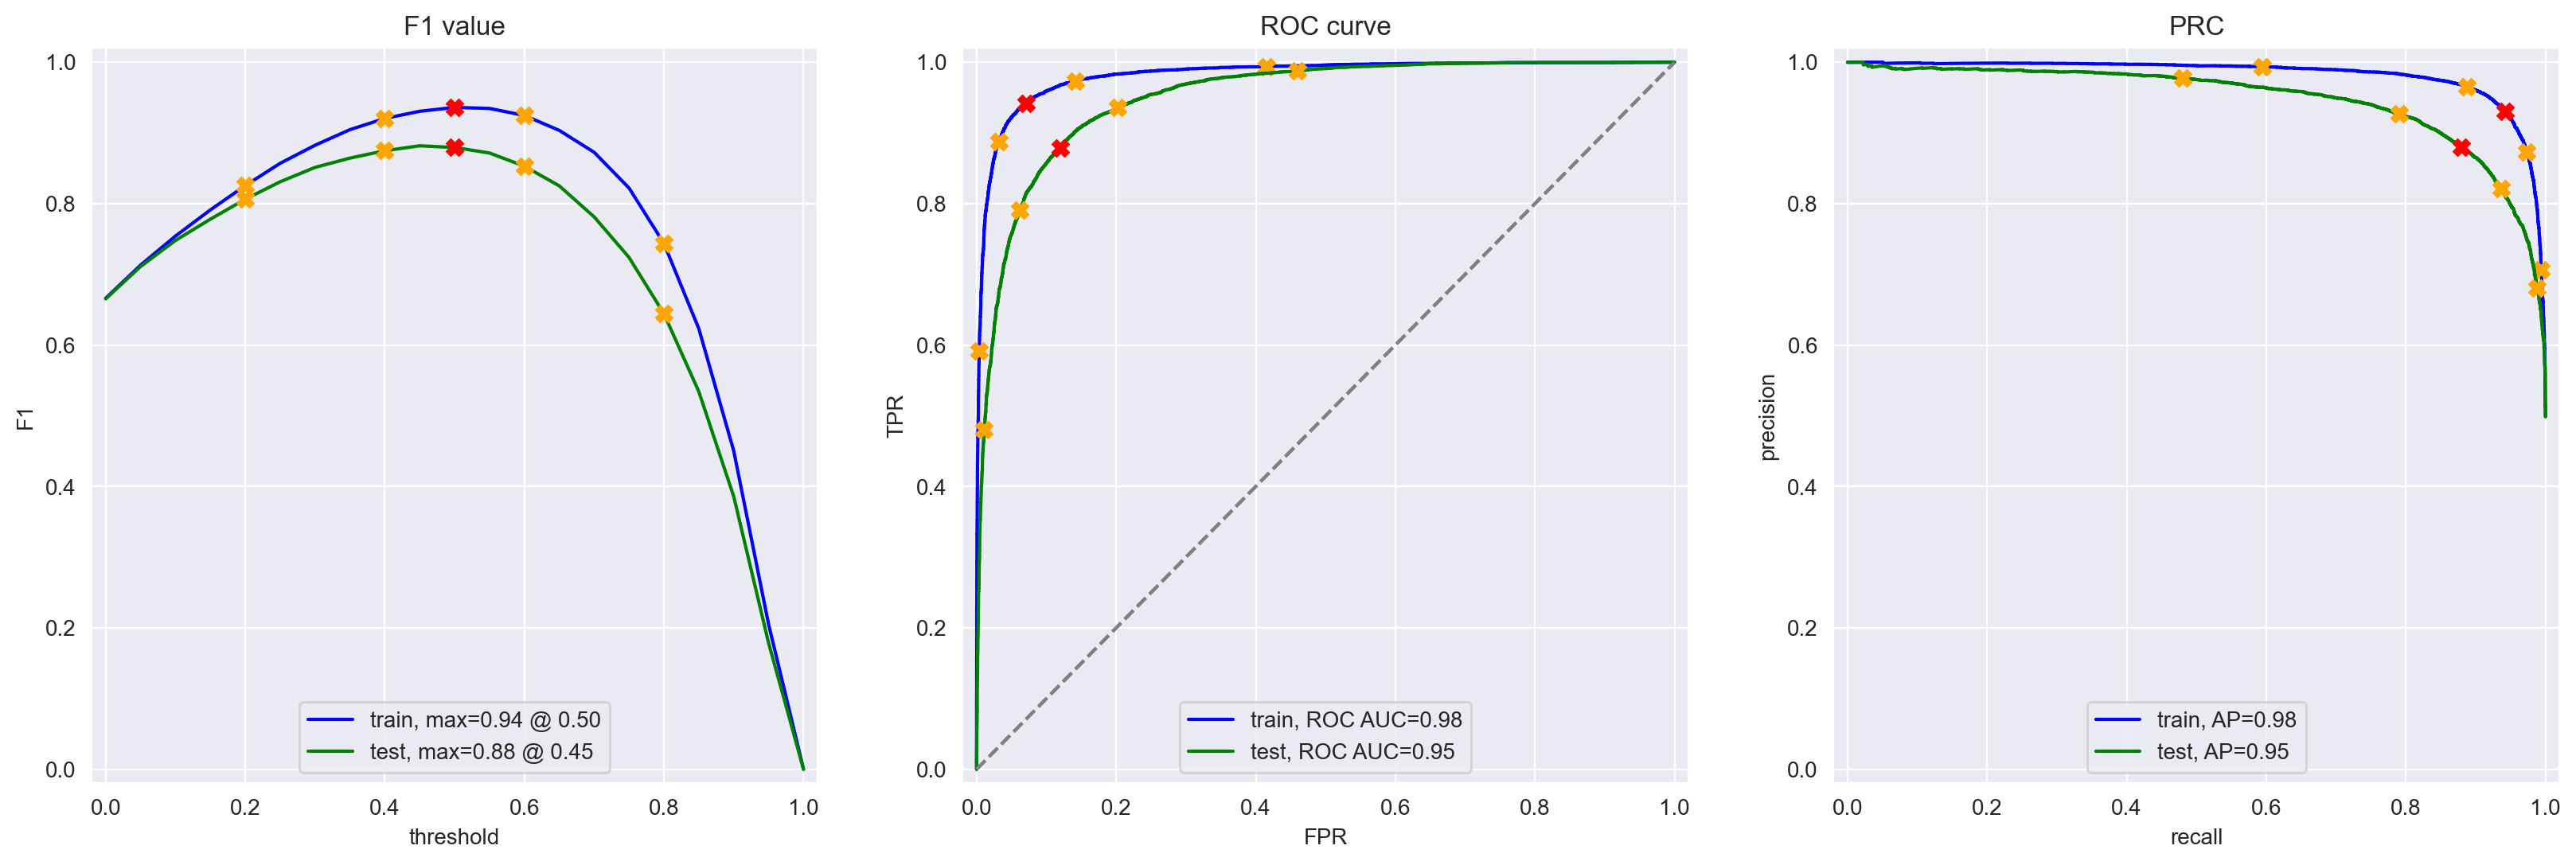

In [82]:
# train our first model with the best hyperparameters
model_1 = LogisticRegression(random_state=12345, solver='saga', penalty= 'l2', C= 1.0)
model_1.fit(train_features_1, train_target)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

The highest F1 of 0.88 was recorded at a threshold of 0.45 for the test set. This is above 0.85 and above F1 of an aleatory model. So, our model has passed the sanity test. We can see an increase in F1 from the threshold of 0.2 to 0.6, which indicate a good precision and sensitivity for detecting positive and negative classes. However, upon reaching a true positive ratio of 0.20, the F1 score drops to approximately 0.6 at a threshold of 0.80, decreasing its precision and sensitivity. This is related to a not so significant class imbalance. By increasing the threshold, our model would increase the proportion of false negatives.

The ROC-AUC in the test set was 0.95, higher than a randomized model. The ROC-AUC curve is high, indicating a good quality of our model, with a higher true positive rate than the false positive rate.

### 5.3 Model 2 - NLTK, TF-IDF and LGBMClassifier <a id='5.3'></a>

Now we will train a preprocessed model with NLTK and with a TF-IDF matrix, but we will use gradient boosting to evaluate it, in this case LGBMClassifier. No need to preprocess the reviews again so we will perform the training and testing of the model with the previously processed features 'train_features_1' and 'test_features_1'.

##### NLTK-LGBM HYPERPARAMETER ADJUSTMENT

In [83]:
%%time 

# set different hyperparameters
params_lightgbm_nltk = {
    'objective'    : ['binary'], 
    'num_leaves'   : [10, 20, 30],
    'learning_rate': [0.1, 0.2, 0.5],
    'n_estimators' : [100], 
    'random_state' : [12345]
}

# calling GridSearchCV to get hyperparameters that maximize F1
nltk_lightgbm = GridSearchCV(LGBMClassifier(),
                      param_grid=params_lightgbm_nltk,
                      scoring='f1',
                      cv=3
                      )

# train the model for hyperparameter fitting
nltk_lightgbm.fit(train_features_1, train_target)

# check the best hyperparameters and F1
print(f'Best hyperparameters LightGBM NLTK: {nltk_lightgbm.best_params_}')
print(f'Best score F1 LightGBM NLTK: {nltk_lightgbm.best_score_}')

Best hyperparameters LightGBM NLTK: {'learning_rate': 0.2, 'n_estimators': 100, 'num_leaves': 20, 'objective': 'binary', 'random_state': 12345}
Best score F1 LightGBM NLTK: 0.8572919129611982


##### MODEL TRAINING AND TESTING

          train  test
Accuracy   0.96  0.87
F1         0.96  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


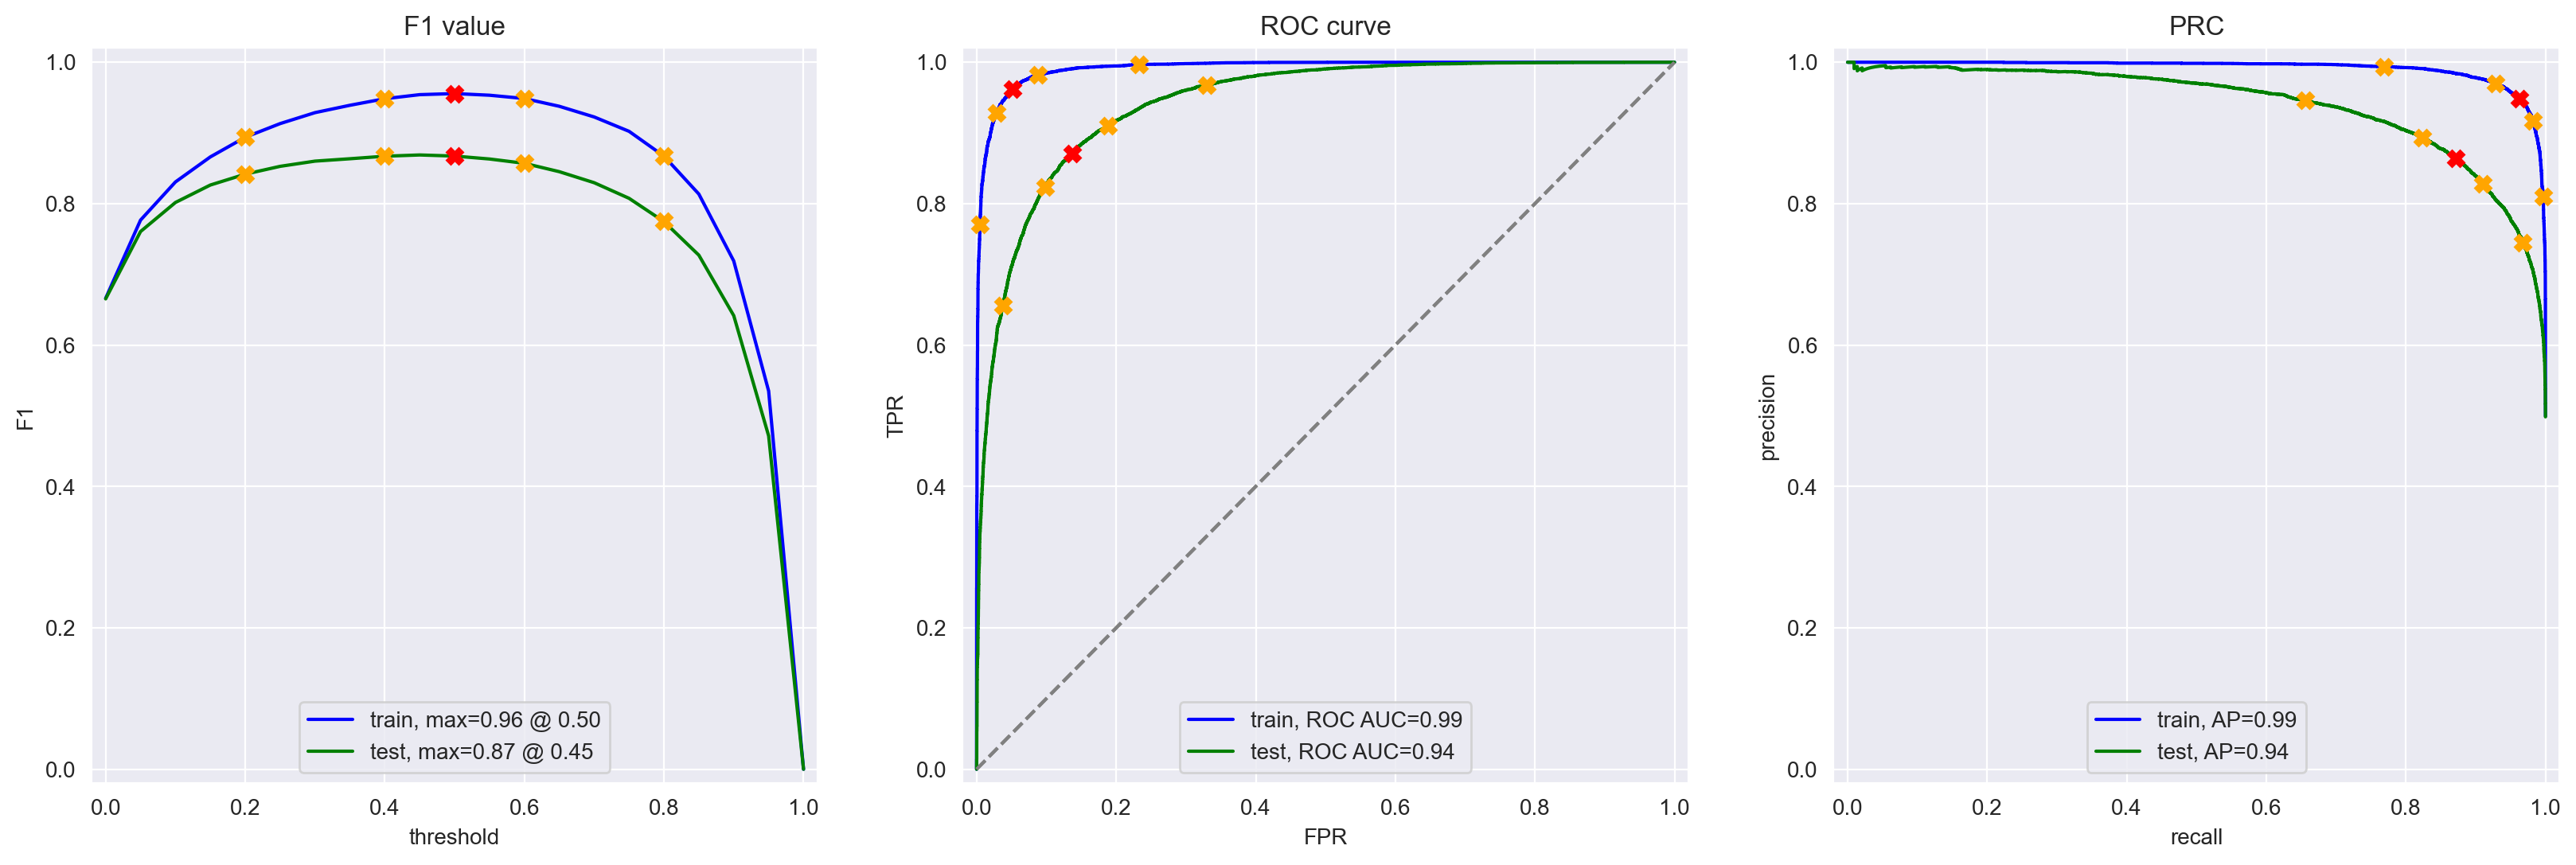

In [84]:
# setting the model with the best hyperparameters
model_2 = LGBMClassifier(learning_rate=0.2,
                         n_estimators=100, 
                         num_leaves=30, 
                         objective='binary',
                         random_state = 12345)

# train the model on the training set
model_2.fit(train_features_1, train_target)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_2, train_features_1, train_target, test_features_1, test_target)

The highest F1 in test set is 0.87 @ 0.45 thresholds and in the train set is 0.96 @ 0.50 thresholds. Even if F1 is higher than 0.85 and passes the sanity test, it is not higher than the one obtained with the logistic regression model and NLTK.

A good sensitivity/precision relationship is observed between thresholds of 0.2 to 0.8. However, from a threshold of 0.80 with a proportion of 0.20 true positives, the F1 score tends to decrease, as previously seen.

In the right graph, we can also see a slight decrease in the precision and recall of the LightGBM model, compared to our logistic regression model.

### 5.4 Model 3 - spaCy, TF-IDF and LR <a id='5.4'></a>

Now we are going to use another text preprocessing method with spaCy library to tokenize and lemmatize user reviews. Spacy, unlike NLTK, has a primary model for text recognition and uses a special pipeline to process incoming text. Once the text is prepared, we train a logistic regression model.

##### TEXT PREPROCESSING WITH SPACY

In [85]:
# loading the model in English and disable some pipeline components
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [86]:
# defining a function that helps the text preprocessing with spacy
def text_preprocessing_3(text):
    
    '''
    Returns the tokenized and lemmatized text from the spaCy library 
    :text: text to be processed
    
    '''
    # dividing text into tokens
    doc = nlp(text)
    
    # getting lemmas from every token
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc] 
    
    # converting the list of lemmas processed into a line of text
    return ' '.join(tokens) 

In [88]:
%%time

# apply the 'text_preprocessing_3' function to our training and testing set
corpus_train_spacy = df_train['review_norm'].apply(text_preprocessing_3)

corpus_test_spacy = df_test['review_norm'].apply(text_preprocessing_3)

CPU times: total: 9min 56s
Wall time: 10min 20s


In [89]:
# save the lemmatized texts of both the training and test set
np.savez_compressed('corpus_spacy.npz', corpus_train_spacy  = corpus_train_spacy , corpus_test_spacy = corpus_test_spacy )

# load the sets of lemmatized texts
with np.load('corpus_spacy.npz', allow_pickle=True) as data:
    corpus_train_spacy = data['corpus_train_spacy']
    corpus_test_spacy = data['corpus_test_spacy']

In [90]:
# Check the size of the text sets
print(corpus_train_spacy.shape)
print(corpus_test_spacy.shape)

(23796,)
(23533,)


##### CREATION OF TF-IDF MATRIX

Now that the reviews preprocessing with Spacy is done, we proceed to transform the text data to numeric data. For this we will transform them into a TF-IDF matrix.

In [91]:
# creating a counter and define stopwords
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=list(stop_words))

# calculating the TF-IDF for the training corpus
train_features_3= tfidf_vectorizer_3.fit_transform(corpus_train_nltk)

# calculating the TF-IDF for the test corpus
test_features_3 = tfidf_vectorizer_3.transform(corpus_test_nltk)

# check the size of the matrixes
print(train_features_3.shape)
print(test_features_3.shape)

(23796, 64308)
(23533, 64308)


##### SPACY LR HYPERPARAMETER ADJUSTMENT

In [92]:
%%time 

# set different hyperparameters
parameters = {
    'penalty' : ['l1','l2'], 
    'solver'  : ['liblinear', 'saga'],
    'C'       : [0.1, 1.0]
}

# calling GridSearchCV to get hyperparameters that maximize F1
spacy_lr = GridSearchCV(LogisticRegression(random_state=12345),
                      param_grid=parameters,
                      scoring='f1',
                      cv=3
                      )

# train the model for hyperparameter fitting
spacy_lr.fit(train_features_3, train_target)

# check the best hyperparameters and F1
print(f'Best hyperparameters LR spaCy: {spacy_lr.best_params_}')
print(f'Best F1 LR spaCy: {spacy_lr.best_score_}')

Best hyperparameters LR spaCy: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
Best F1 LR spaCy: 0.8698100124449709
CPU times: total: 18.7 s
Wall time: 19.2 s


##### MODEL TRAINING AND TESTING

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


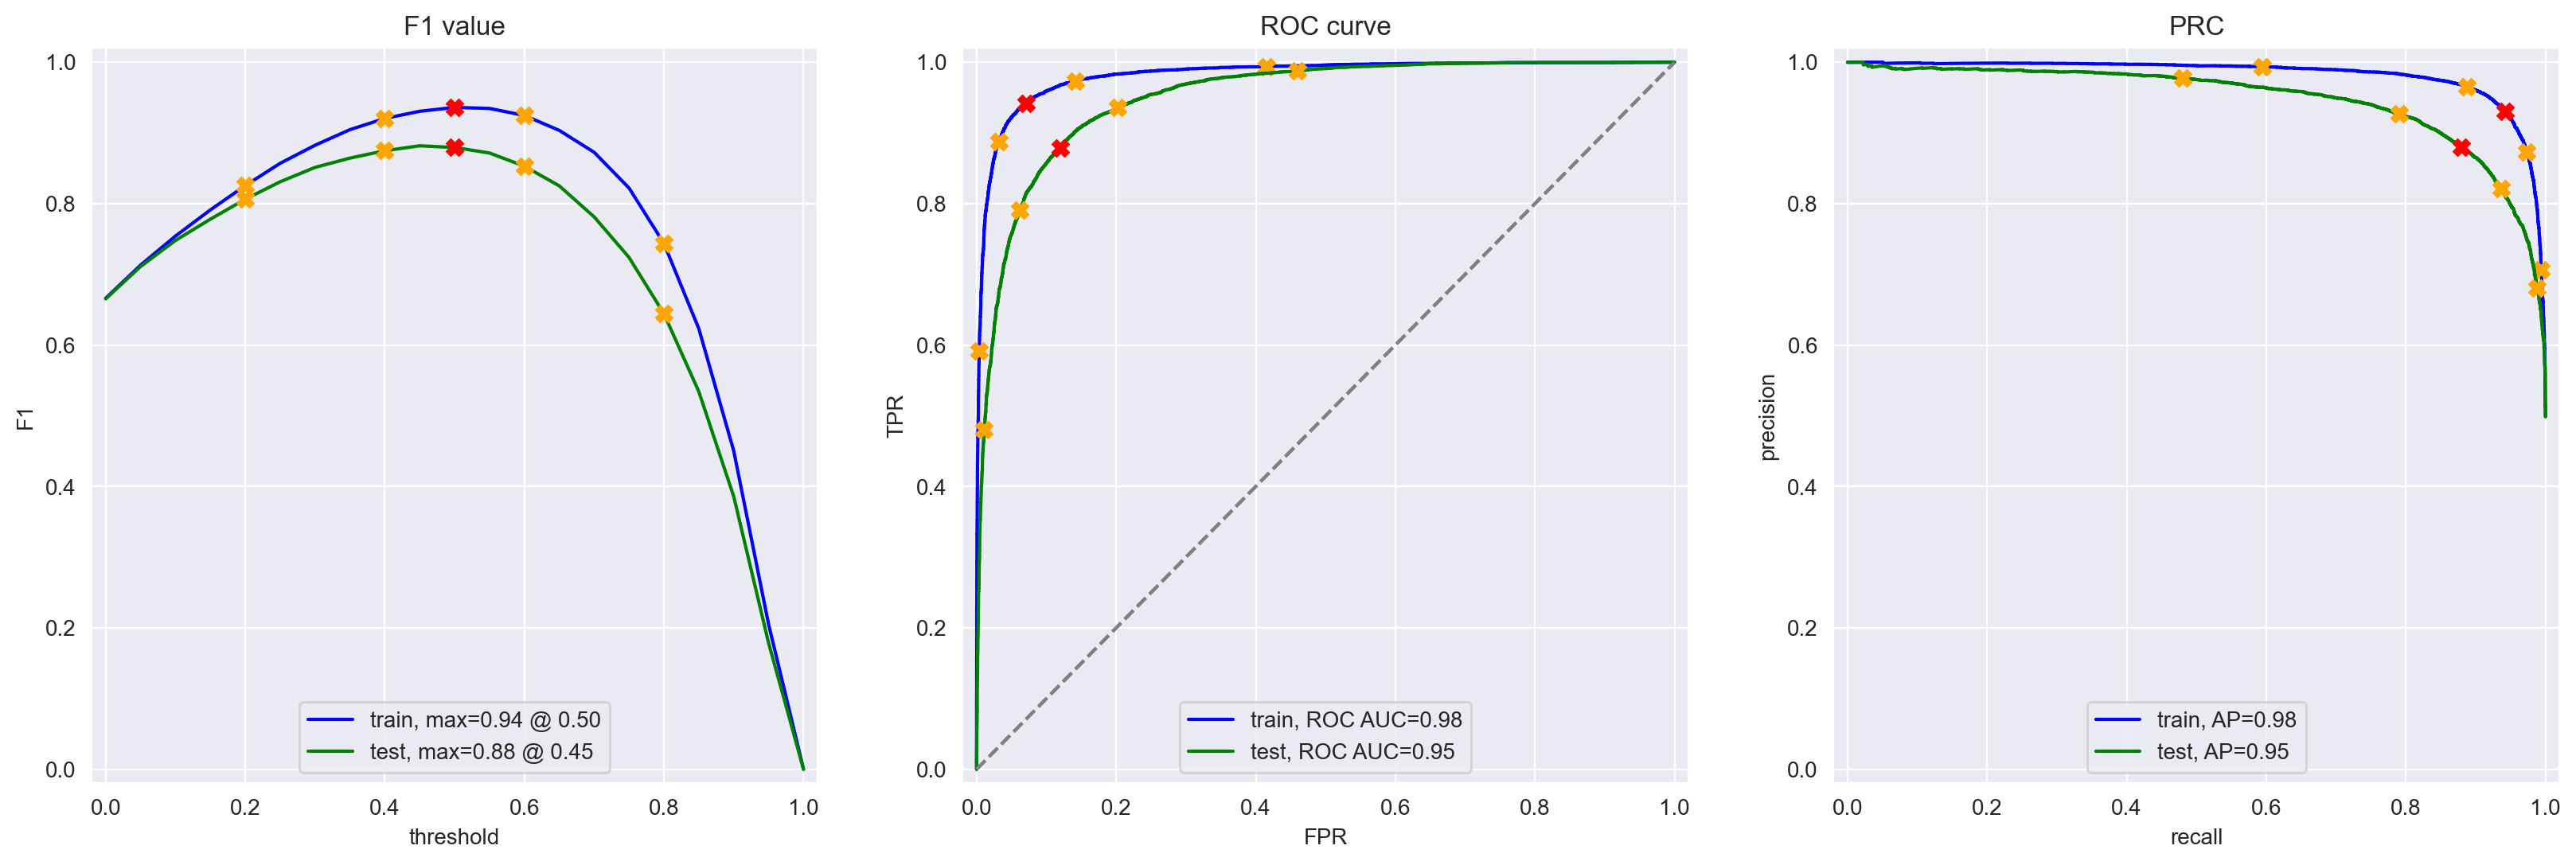

In [93]:
# setting the model with the best hyperparameters
model_3 = LogisticRegression(random_state=12345, solver='saga', penalty='l2', C= 1.0)

# train the model on the training set
model_3.fit(train_features_3, train_target)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

The highest F1 in test set is 0.88 @ 0.45 thresholds and in the train set is 0.94 @ 0.50 thresholds. F1 is higher than 0.85 so it passes the sanity test. It should be noted that F1 is similar to the logistic regression model with NLTK preprocessing, so we can establish that the tokenization and lemmatization method does not influence the performance of the model.

### 5.5 Model 4 - spaCy, TF-IDF and LGBMClassifier <a id='5.5'></a>

As done before with NLTK, we now build a gradient boosting model with the text preprocessed in spaCy and in a TD-IDF matrix.

##### SPACY TF-IDF HYPERPARAMETER ADJUSTMENT

In [94]:
%%time 

# set different hyperparameters
parameters_lightgbm = {
    'objective' : ['binary'], 
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.1, 0.2, 0.5],
    'n_estimators' : [100] 
}

# calling GridSearchCV to get hyperparameters that maximize F1
spacy_lightgbm = GridSearchCV(LGBMClassifier(random_state=12345),
                      param_grid=parameters_lightgbm,
                      scoring='f1',
                      cv=3
                      )

# train the model for hyperparameter fitting
spacy_lightgbm.fit(train_features_3, train_target)

# check the best hyperparameters and F1
print(f'Best hyperparameters LightGBM Spacy: {spacy_lightgbm.best_params_}')
print(f'Best F1 LightGBM Spacy: {spacy_lightgbm.best_score_}')

Best hyperparameters LightGBM Spacy: {'learning_rate': 0.2, 'n_estimators': 100, 'num_leaves': 20, 'objective': 'binary'}
Best F1 LightGBM Spacy: 0.8572919129611982
CPU times: total: 37min 39s
Wall time: 2min 54s


##### MODEL TRAINING AND TESTING

          train  test
Accuracy   0.93  0.86
F1         0.93  0.86
APS        0.98  0.94
ROC AUC    0.98  0.94


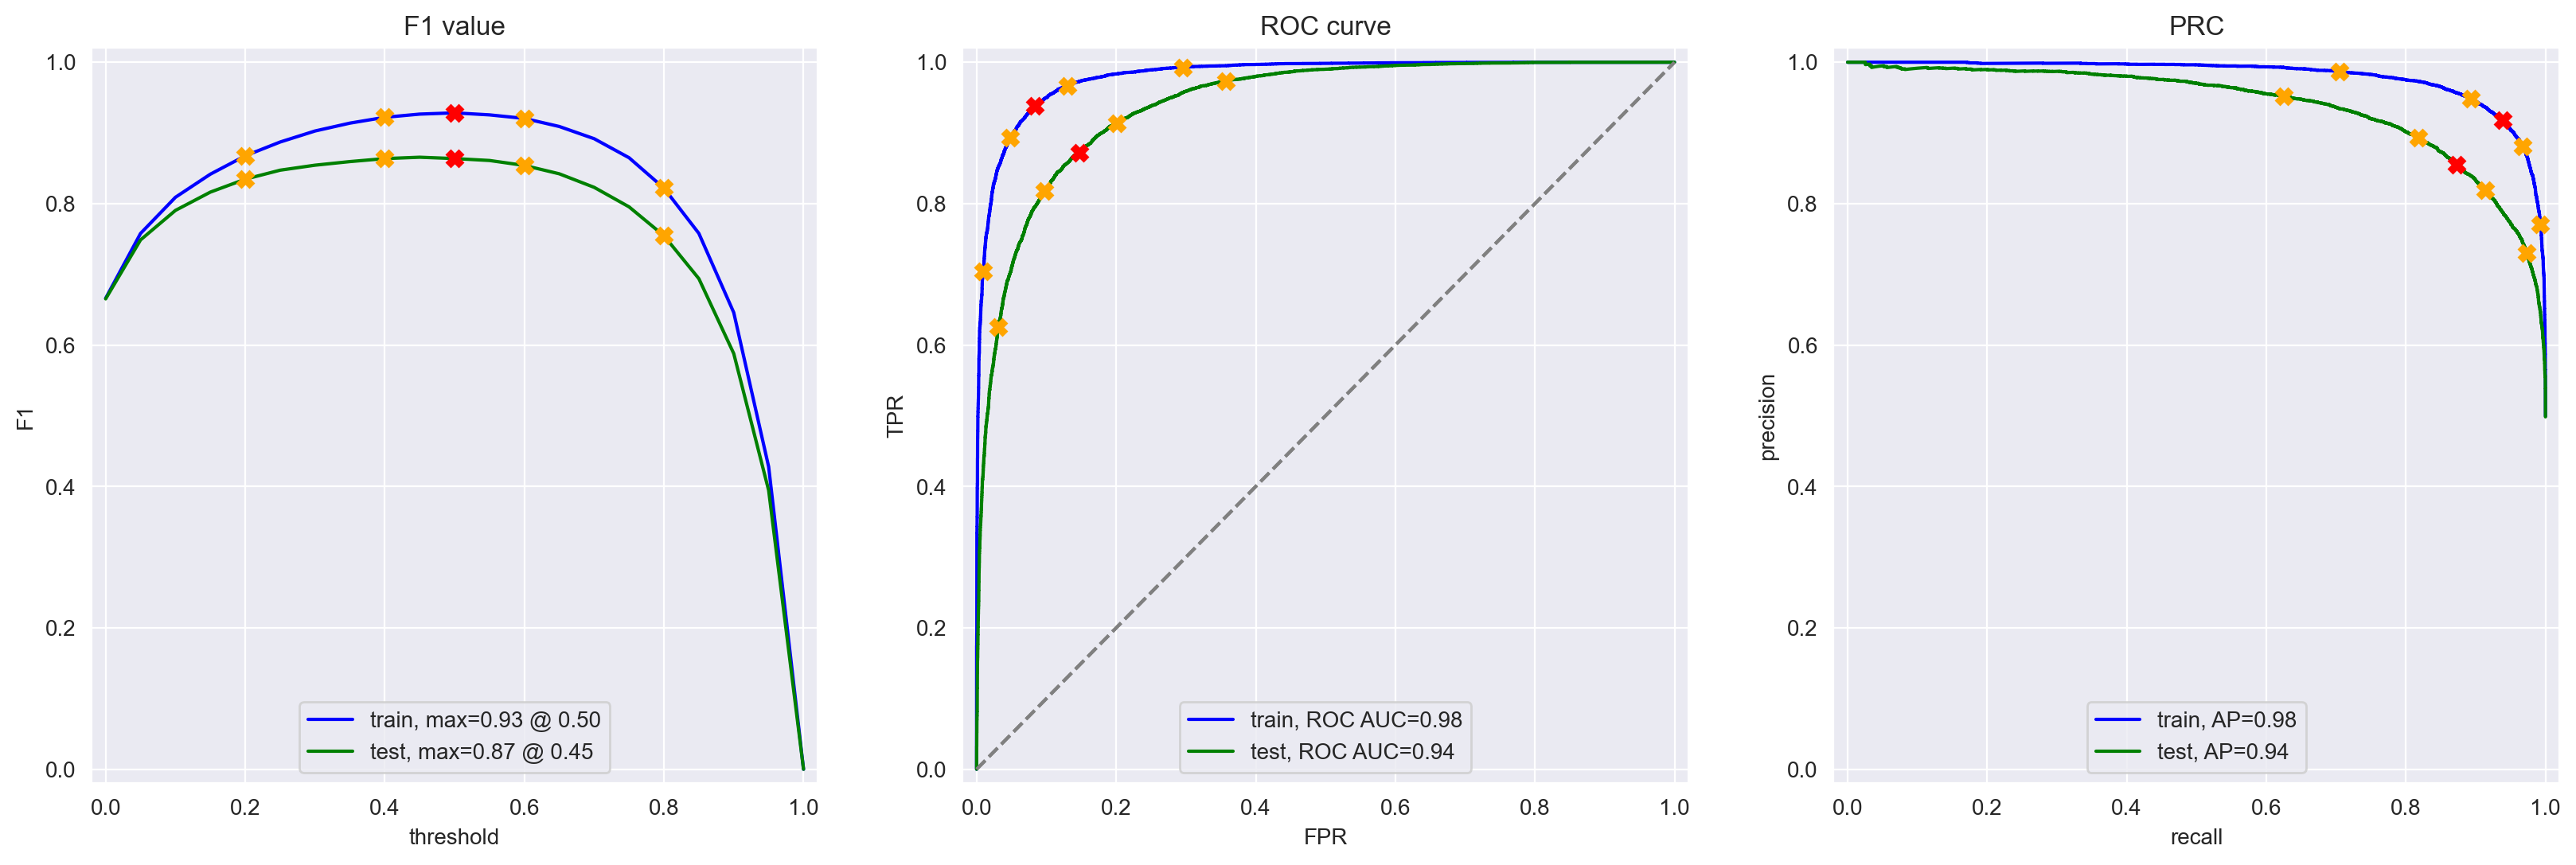

In [95]:
# setting the model with the best hyperparameters
model_4 = LGBMClassifier(learning_rate=0.2,
                             n_estimators=100, 
                             num_leaves=20, 
                             objective='binary',
                             random_state=12345)

# train the model on the training set
model_4.fit(train_features_3, train_target)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

The highest F1 in test set is 0.87 @ 0.45 thresholds and in the train set is 0.93 @ 0.50 thresholds. The F1 is similar to the one obtained in  LightGBM model with NLTK, so once again it is verified that the type of preprocessing does not influence the performance of a predictive model. Although F1 is above 0.85, it is not as high as logistic regression.

We observe again a good sensitivity/precision relationship at thresholds of 0.2 to 0.8, with a decrease of F1 when the proportion of true positives is 0.20.

### 5.6 Model 5 - BERT LR <a id='5.6'></a>

We have worked with NLTK and Spacy, now we are going to try another preprocessing method: BERT. This consists of a neural network model for language representation, able to understand the context of a complete text and not just short sentences.

For text preprocessing, a model previously trained in large text corpus is used, which is responsible for finding out those unknown or masked words and if there is a relationship between the words in the text.

We now carry out the text pre-processing with BERT and later we will train a logistic regression and a gradient boosting model.

In [98]:
# initalizing tokenizer with BertTokenizer() instance with the name of the previously trained model
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

# initalizing BertConfig() with the description of the model configuration
config = transformers.BertConfig.from_pretrained('bert-base-uncased')

# initalizing model Bert Model() and pass the file with the previously trained model and its configuration
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We build now the function 'BERT_text_to_embeddings' that will return BERT word embeddings of 512 words and with a batch size of 100. 

Since BERT requires large computational power and it would take several hours to get the complete set inserted, the data will be pre-processed in Google Colab and then the obtained training and test set will be uploaded.

In [127]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#     '''
#     Returns inserts of BERT words
    
#     :texts: text from which inserts will be obtained
#     :max_length: maximum length of each vector
#     :batch_size: batch size for creation of inserts
#     :force_device: device to be used, CUDA or CPU
#     :disable_progress_bar: enable or disable progress bar
    
#     '''
#     # initialize lists for ids and attention_masks
#     ids_list = []
#     attention_mask_list = []

#     # tokenizing the text and add ids and attention_mask to the corresponding lists
#     for input_text in texts:
#         ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
#         padded = np.array(ids + [0]*(max_length - len(ids))) # fill the vectors with zero 
#         attention_mask = np.where(padded != 0, 1, 0) # create a mask for important tokens
#         ids_list.append(padded)
#         attention_mask_list.append(attention_mask)
    
#     # setting the device that we will use
#     if force_device is not None:
#         device = torch.device(force_device)
#     else:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
#     # defining the progress bar
#     model.to(device)
#     if not disable_progress_bar:
#         print(f'Uso del dispositivo {device}.')
    
#     # get the inserts from a loop, in this case the batch size will be 100
#     embeddings = []

#     for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        
#         # transforming the data into a tensor format, Torch's multidimensional vector
#         ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
#         attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
        
#         # passing the data and mask to the model to get inserted for the batch
#         with torch.no_grad():            
#             model.eval()
#             batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#         embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy()) # extract tensor elements 
        
#     # getting the features matrix
#     return np.concatenate(embeddings)

In [133]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    """
    parameters:
     texts to process
     max_length total tokens
     batch_size for batches

    return features process
    """
    batch_size = 25 # reduce memory requirements

    #  ids token list of size "max_length" with padding of 0, and attention mask list
    ids_list = [] 
    attention_mask_list = [] 

    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length) 
        padded = np.array(ids + [0] * (max_length - len(ids))) # create an array where the first values are those of 'ids' the rest 0.
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask) 
    
    # Device to use to execute operations with PyTorch,
    # depending on the value of force_device, and whether a GPU is available.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Uso del dispositivo {device}.')
    model.to(device)


    # get inserted in batches
    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        # Create ids token batch. Union of ids vectors to a tensor
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        
        # Create attention_mask batch. Union of attention mask vectors to a tensor
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i : batch_size * ( i + 1)])
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

Since running BERT for thousands of texts can take a long time on the CPU (at least several hours) we will use 500 reviews in each environment.

In [134]:
# Target 500 train, 500 test
y_train_500 = df_train['pos'].iloc[0:500]
y_test_500  = df_test['pos'].iloc[0:500]

# Features 500 train, 500 test
X_train_500 = df_train['review_norm'].iloc[0:500]
X_test_500  = df_test['review_norm'].iloc[0:500]

In [135]:
# get features for the training and testing set
train_features_9 = BERT_text_to_embeddings(X_train_500, force_device='cuda')

test_features_9 = BERT_text_to_embeddings(X_test_500, force_device='cuda')

Uso del dispositivo cpu.


  0%|          | 0/20 [00:00<?, ?it/s]

Uso del dispositivo cpu.


  0%|          | 0/20 [00:00<?, ?it/s]

In [136]:
# check the size of the training set
print(df_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(500, 768)
(23796,)


In [137]:
# check the size of the test set
print(df_test['review_norm'].shape)
print(test_features_9.shape)
print(test_target.shape)

(23533,)
(500, 768)
(23533,)


##### BERT LR HYPERPARAMETER ADJUSTMENT

In [139]:
%%time

# set different hyperparameters
params_lr_bert = {
    'penalty' : ['l1','l2'], 
    'solver'  : ['liblinear', 'saga'],
    'C'       : [0.1, 1.0]
}

# calling GridSearchCV to get hyperparameters that maximize F1
bert_lr = GridSearchCV(LogisticRegression(random_state=12345),
                      param_grid=params_lr_bert,
                      scoring='f1',
                      cv=3
                      )

# train the model for hyperparameter fitting
bert_lr.fit(train_features_9, y_train_500)

# check the best hyperparameters and F1
print(f'Best hyperparameters LR BERT: {bert_lr.best_params_}')
print(f'Best F1 LR BERT: {bert_lr.best_score_}')

Best hyperparameters LR BERT: {'C': 1.0, 'penalty': 'l1', 'solver': 'saga'}
Best F1 LR BERT: 0.8188696185345771
CPU times: total: 8.58 s
Wall time: 8.71 s


##### MODEL TRAINING AND TESTING

          train  test
Accuracy   0.82  0.75
F1         0.83  0.77
APS        0.92  0.84
ROC AUC    0.90  0.82


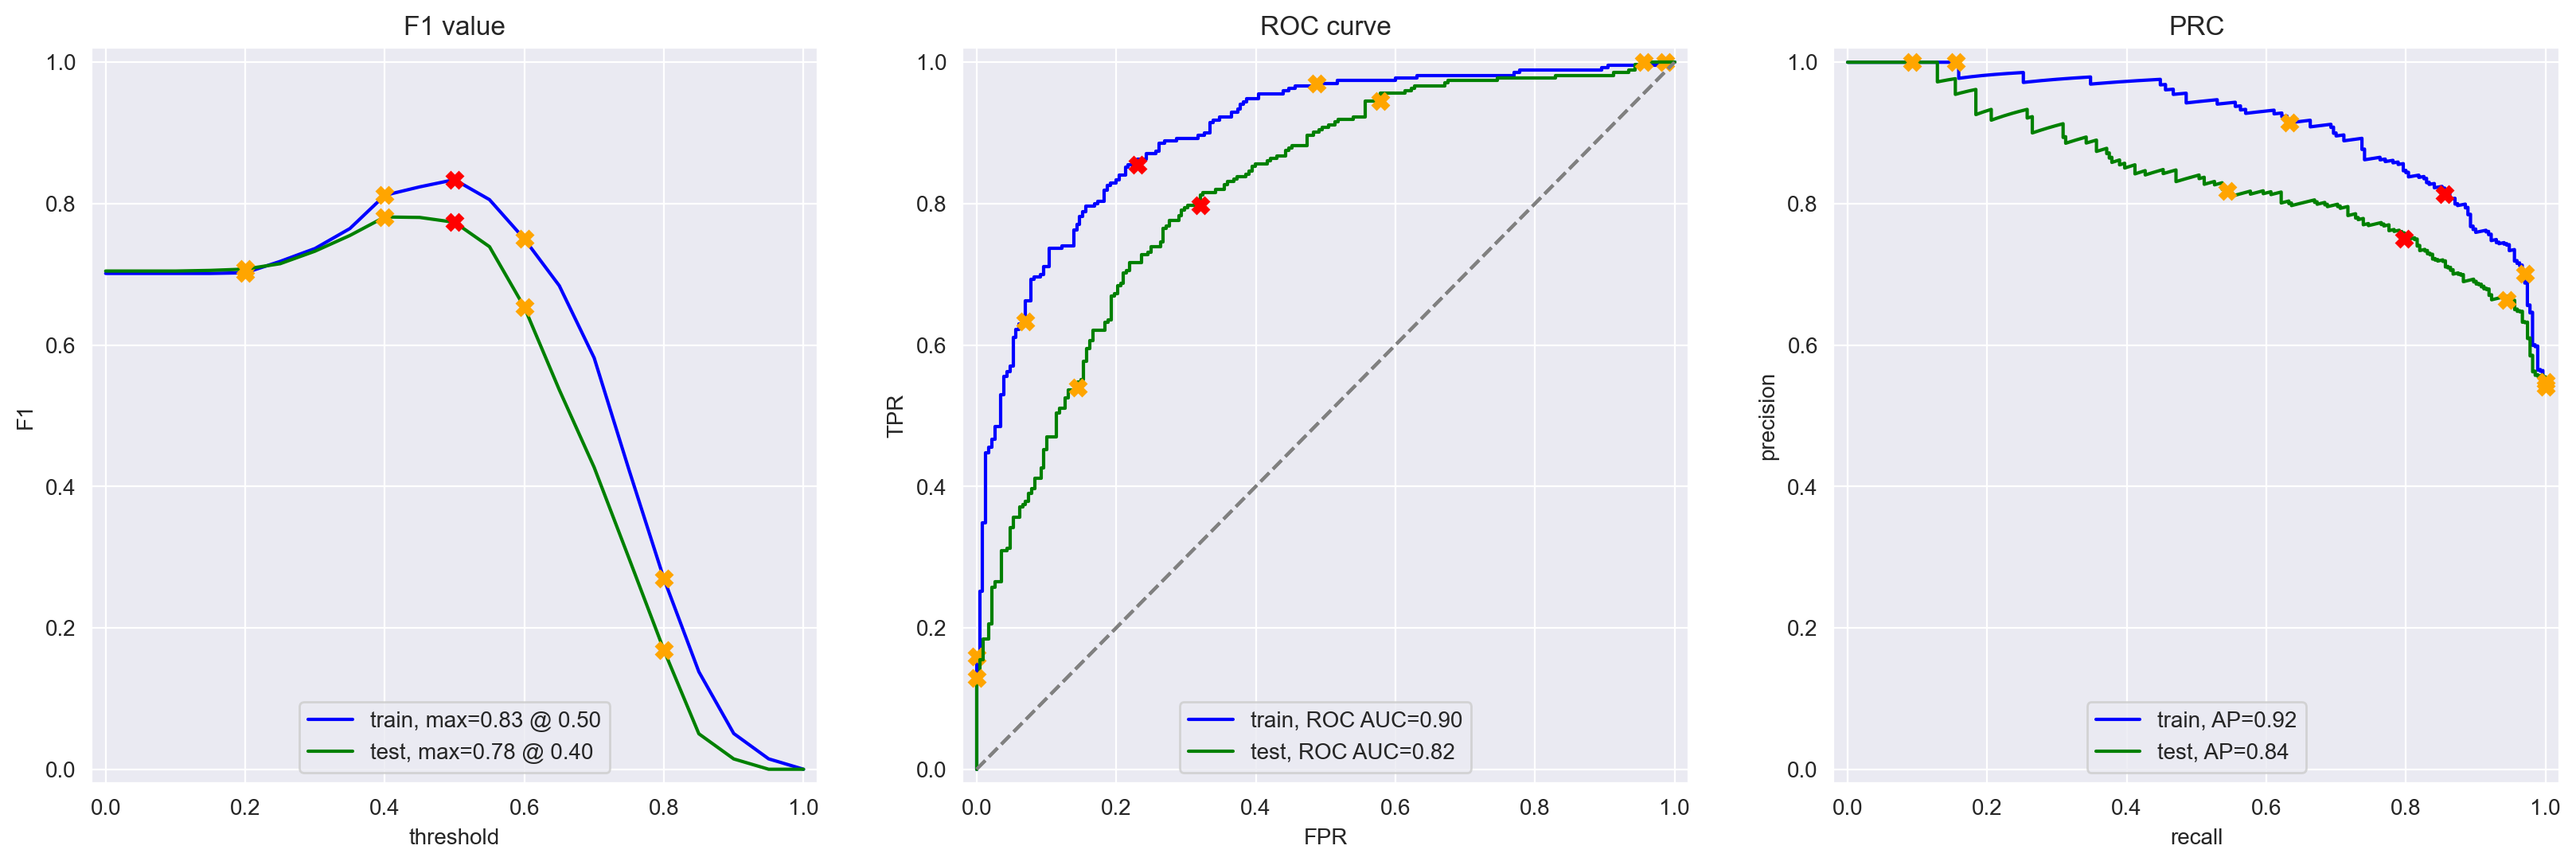

In [143]:
# setting the model with the best hyperparameters
model_9 = LogisticRegression(random_state=12345, solver='saga', penalty='l1', C=0.1)

# train the model on the training set
model_9.fit(train_features_9, y_train_500)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_9, train_features_9, y_train_500, test_features_9, y_test_500)

For the logistic regression model with BERT, F1 is lower than the minimum threshold of 0.85. Maybe beacause we took into calculation only 500 texts. Anyway, BERT model does not reach the performance of logistic regression models preprocessed with NLTK and spaCy.

### 5.7 Model 6 - BERT LGBMClassifier <a id='5.7'></a>

##### BERT LGBM HYPERPARAMETER ADJUSTMENT

In [145]:
# set different hyperparameters
params_lgbm_bert = {
    'objective' : ['binary'], 
    'num_leaves': [10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [100] 
}

# calling GridSearchCV to get hyperparameters that maximize F1
bert_lightgbm = GridSearchCV(LGBMClassifier(random_state=12345),
                    param_grid=params_lgbm_bert,
                    scoring='f1',
                    cv=3
                    )

# train the model for hyperparameter fitting
bert_lightgbm.fit(train_features_9, y_train_500)

print(f'Best hyperparameters LightGBM BERT: {bert_lightgbm.best_params_}')
print(f'Best F1 LightGBM BERT: {bert_lightgbm.best_score_}')

Best hyperparameters LightGBM BERT: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 20, 'objective': 'binary'}
Best F1 LightGBM BERT: 0.7890256257100359


##### MODEL TRAINING AND TESTING

          train  test
Accuracy    1.0  0.79
F1          1.0  0.81
APS         1.0  0.88
ROC AUC     1.0  0.86


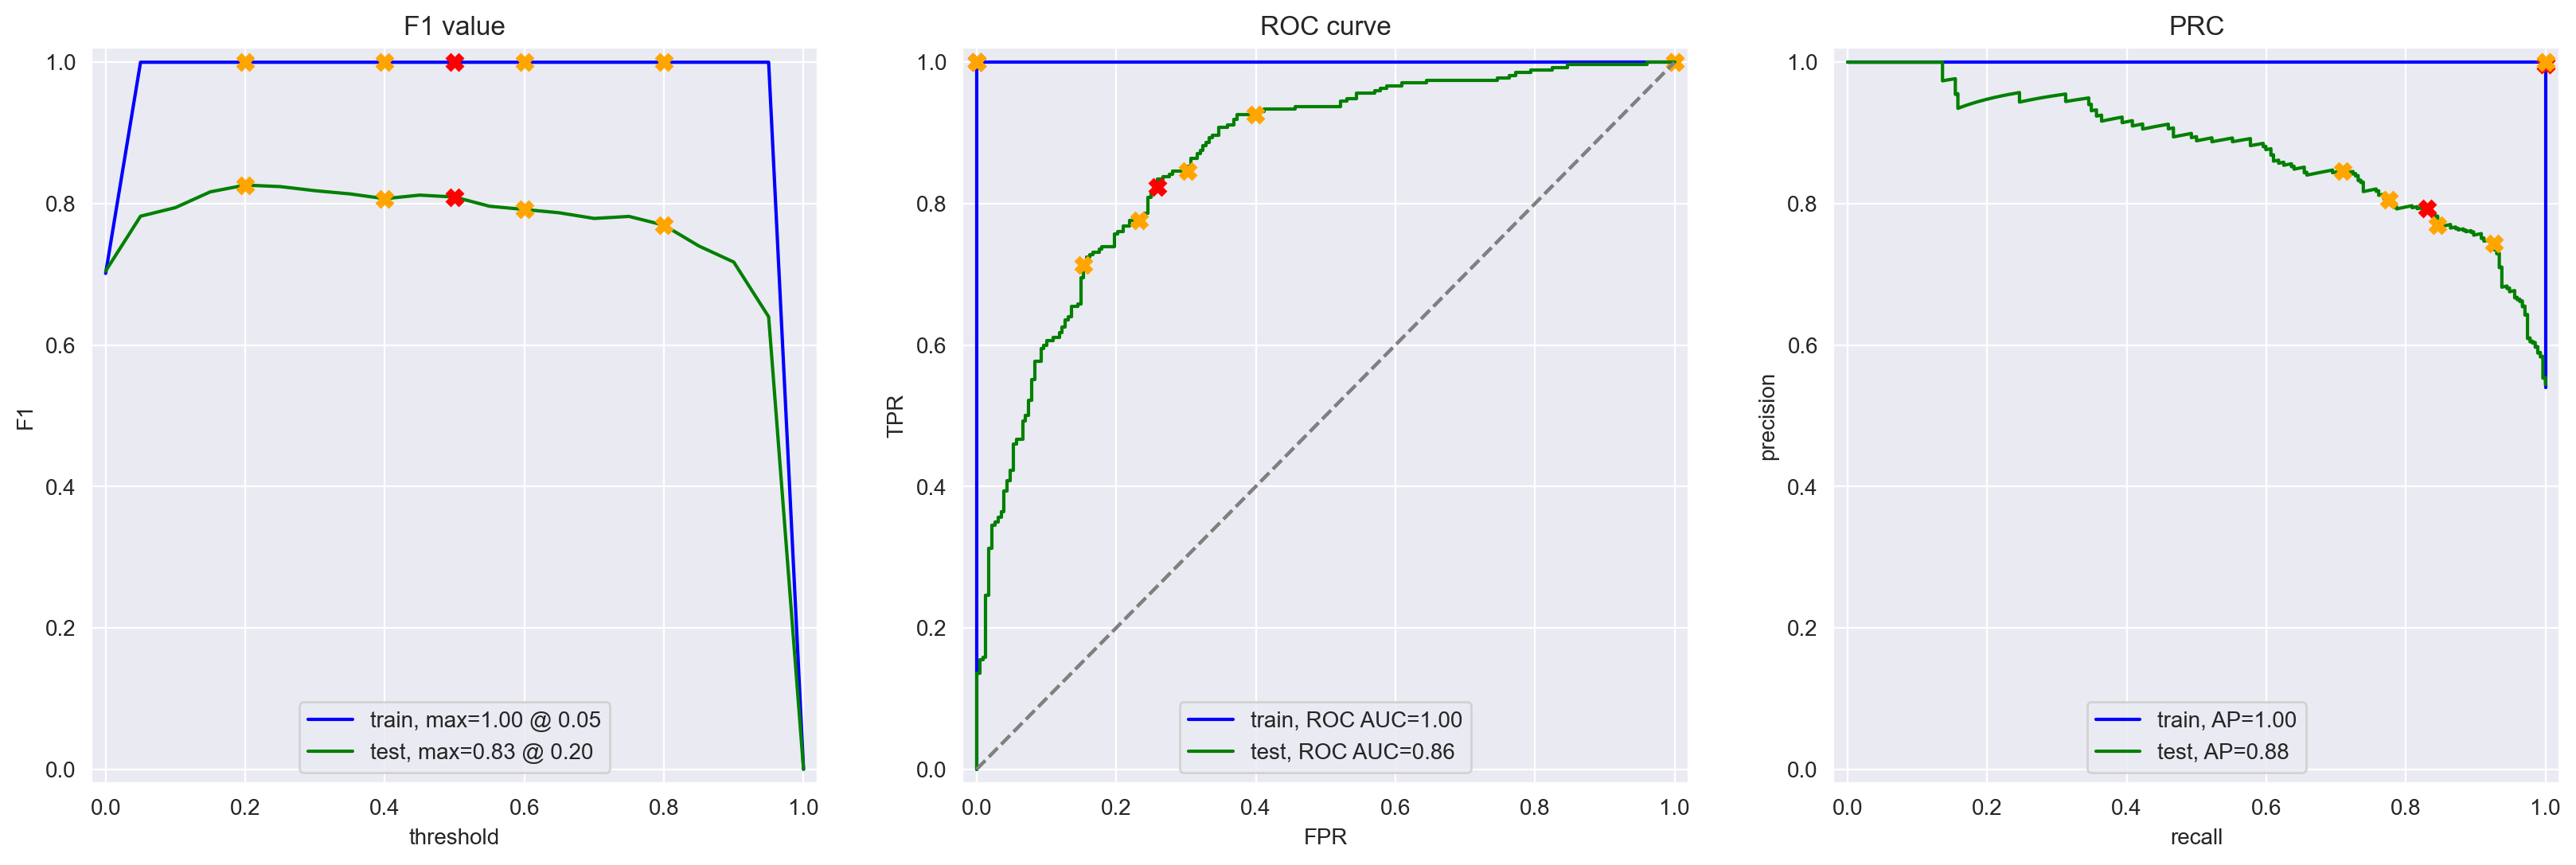

In [146]:
#  setting the model with the best hyperparameters
model_10 = LGBMClassifier(random_state=12345,
                        learning_rate=0.1,
                        num_leaves=20,
                        n_estimators=100,
                        objective='binary')

# train the model on the training set
model_10.fit(train_features_9, y_train_500)

# evaluate the model in test set through the function 'evaluate_model'
evaluate_model(model_10, train_features_9, y_train_500, test_features_9, y_test_500)

## Stage 6. Models quality <a id='6'></a>

Lets now invent some reviews and test how each of our models performs by predicting the positive or negative sentiment of each review. We write four positive and four negative reviews.

In [108]:
# reviews list
my_reviews = pd.DataFrame([
    'This film has got to be the epitome of terrible writing and should be a classroom example of "what not to do" when writing a screenplay.',
    'It is sadly however yet another film seen recently that to me was incredibly disappointing.',
    'I was really fascinated with the movie',
    'I watch a lot of movies and I like to give them all a chance just in case there is something interesting or exciting. Unfortunately this movie has none of these features.',    
    'Loved this movie. Joshua Caldwell actually takes the time for the audience to get to know and understand the characters.',
    'Not a bad movie, typical "on the run ex-agent" movie with a reasonable storyline.',
    'I rarely stop watching a movie although how crappy it is. Well for this one I made an exception since its beyond boring.',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.'
], columns=['review'])

# normalizing the list of reviews with our 'clear_text' function
my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)
my_reviews['pos'] = [0, 0, 1, 0, 1, 1, 0, 1]

my_reviews

,review,review_norm,pos
0,This film has got to be the epitome of terribl...,this film has got to be the epitome of terribl...,0
1,It is sadly however yet another film seen rece...,it is sadly however yet another film seen rece...,0
2,I was really fascinated with the movie,i was really fascinated with the movie,1
3,I watch a lot of movies and I like to give the...,i watch a lot of movies and i like to give the...,0
4,Loved this movie. Joshua Caldwell actually tak...,loved this movie joshua caldwell actually take...,1
5,"Not a bad movie, typical ""on the run ex-agent""...",not a bad movie typical on the run ex agent mo...,1
6,I rarely stop watching a movie although how cr...,i rarely stop watching a movie although how cr...,0
7,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,1


### 6.1 Model 1 <a id='6.1'></a>

In [111]:
# setting the text and sentiment variables based on reviews and their rating
texts = my_reviews['review_norm']
sentiment = my_reviews['pos']

# get the predictions and probabilities for model 1
my_reviews_pred = model_1.predict(tfidf_vectorizer_1.transform(texts.apply(lambda x: nltk_lemmatizer(x))))
my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts.apply(lambda x: nltk_lemmatizer(x))))[:, 1]

print('Pos:'+'  '+'Pred:'+'  '+'Proba:'+'  '+'Review:')
for i, review in enumerate(texts.str.slice(0, 90)):
    print(f'{sentiment[i]}:    {my_reviews_pred[i]}:     {my_reviews_pred_prob[i]:.2f}:   {review}')

Pos:  Pred:  Proba:  Review:
0:    0:     0.14:   this film has got to be the epitome of terrible writing and should be a classroom example 
0:    0:     0.11:   it is sadly however yet another film seen recently that to me was incredibly disappointing
1:    0:     0.46:   i was really fascinated with the movie
0:    0:     0.23:   i watch a lot of movies and i like to give them all a chance just in case there is somethi
1:    1:     0.80:   loved this movie joshua caldwell actually takes the time for the audience to get to know a
1:    0:     0.13:   not a bad movie typical on the run ex agent movie with a reasonable storyline
0:    0:     0.17:   i rarely stop watching a movie although how crappy it is well for this one i made an excep
1:    1:     0.53:   the movie had its upsides and downsides but i feel like overall it's a decent flick i coul


So, model 1 with NLTK LR was able to correctly predict sentiment for 6 of 8 reviews, failing when trying to predict two positive reviews.

### 6.2 Model 2 <a id='6.2'></a>

In [112]:
# getting probabilities and predictions for the model 2
my_reviews_pred = model_2.predict(tfidf_vectorizer_1.transform(texts.apply(lambda x: nltk_lemmatizer(x))))
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_1.transform(texts.apply(lambda x: nltk_lemmatizer(x))))[:, 1]

print('Pos:'+'  '+'Pred:'+'  '+'Proba:'+'  '+'Review:')
for i, review in enumerate(texts.str.slice(0, 90)):
    print(f'{sentiment[i]}:    {my_reviews_pred[i]}:     {my_reviews_pred_prob[i]:.2f}:   {review}')

Pos:  Pred:  Proba:  Review:
0:    0:     0.10:   this film has got to be the epitome of terrible writing and should be a classroom example 
0:    0:     0.25:   it is sadly however yet another film seen recently that to me was incredibly disappointing
1:    0:     0.46:   i was really fascinated with the movie
0:    0:     0.32:   i watch a lot of movies and i like to give them all a chance just in case there is somethi
1:    1:     0.83:   loved this movie joshua caldwell actually takes the time for the audience to get to know a
1:    0:     0.14:   not a bad movie typical on the run ex agent movie with a reasonable storyline
0:    0:     0.31:   i rarely stop watching a movie although how crappy it is well for this one i made an excep
1:    1:     0.52:   the movie had its upsides and downsides but i feel like overall it's a decent flick i coul


So, model 2 with NLTK LGBM was able to correctly predict sentiment for 6 of 8 reviews, failing when trying to predict two positive reviews, like in the previous case. Maybe the use of few words or little information confuse the model, making it unable to understand the general context of the sentence.

### 6.3 Model 3 <a id='6.3'></a>

In [113]:
# getting probabilities and predictions for the model 3
my_reviews_pred = model_3.predict(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

print('Pos:'+'  '+'Pred:'+'  '+'Proba:'+'  '+'Review:')
for i, review in enumerate(texts.str.slice(0, 90)):
    print(f'{sentiment[i]}:    {my_reviews_pred[i]}:     {my_reviews_pred_prob[i]:.2f}:   {review}')

Pos:  Pred:  Proba:  Review:
0:    0:     0.10:   this film has got to be the epitome of terrible writing and should be a classroom example 
0:    0:     0.13:   it is sadly however yet another film seen recently that to me was incredibly disappointing
1:    1:     0.58:   i was really fascinated with the movie
0:    0:     0.20:   i watch a lot of movies and i like to give them all a chance just in case there is somethi
1:    1:     0.74:   loved this movie joshua caldwell actually takes the time for the audience to get to know a
1:    0:     0.13:   not a bad movie typical on the run ex agent movie with a reasonable storyline
0:    0:     0.23:   i rarely stop watching a movie although how crappy it is well for this one i made an excep
1:    1:     0.55:   the movie had its upsides and downsides but i feel like overall it's a decent flick i coul


So, model 3 with spaCy LR was able to correctly predict sentiment for 7 of 8 reviews, failing just one time when trying to predict a positive review. Maybe because there is a negative word like 'bad' inside positive reviews. 

### 6.4 Model 4 <a id='6.4'></a>

In [114]:
# set the vectorizer for model 4
tfidf_vectorizer_4 = tfidf_vectorizer_3

# get the predictions and probabilities for model 4
my_reviews_pred = model_4.predict(tfidf_vectorizer_4.transform(texts))
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

print('Pos:'+'  '+'Pred:'+'  '+'Proba:'+'  '+'Review:')
for i, review in enumerate(texts.str.slice(0, 90)):
    print(f'{sentiment[i]}:    {my_reviews_pred[i]}:     {my_reviews_pred_prob[i]:.2f}:   {review}')

Pos:  Pred:  Proba:  Review:
0:    0:     0.16:   this film has got to be the epitome of terrible writing and should be a classroom example 
0:    0:     0.26:   it is sadly however yet another film seen recently that to me was incredibly disappointing
1:    1:     0.60:   i was really fascinated with the movie
0:    0:     0.34:   i watch a lot of movies and i like to give them all a chance just in case there is somethi
1:    1:     0.84:   loved this movie joshua caldwell actually takes the time for the audience to get to know a
1:    0:     0.19:   not a bad movie typical on the run ex agent movie with a reasonable storyline
0:    0:     0.39:   i rarely stop watching a movie although how crappy it is well for this one i made an excep
1:    1:     0.59:   the movie had its upsides and downsides but i feel like overall it's a decent flick i coul


Like the previous model, spaCy LGBM was able to correctly predict sentiment for 7 of 8 reviews, failing just one time when trying to predict a positive review.

### 6.5 Model 5 <a id='6.5'></a>

In [148]:
# get the word inserts from BERT
my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# get the predictions and probabilities for model 9
my_reviews_pred = model_9.predict(my_reviews_features_9)
my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

print('Pos:'+'  '+'Pred:'+'  '+'Proba:'+'  '+'Review:')
for i, review in enumerate(texts.str.slice(0, 90)):
    print(f'{sentiment[i]}:    {my_reviews_pred[i]}:     {my_reviews_pred_prob[i]:.2f}:   {review}')

Uso del dispositivo cpu.
Pos:  Pred:  Proba:  Review:
0:    0:     0.27:   this film has got to be the epitome of terrible writing and should be a classroom example 
0:    0:     0.40:   it is sadly however yet another film seen recently that to me was incredibly disappointing
1:    0:     0.24:   i was really fascinated with the movie
0:    0:     0.32:   i watch a lot of movies and i like to give them all a chance just in case there is somethi
1:    1:     0.77:   loved this movie joshua caldwell actually takes the time for the audience to get to know a
1:    0:     0.47:   not a bad movie typical on the run ex agent movie with a reasonable storyline
0:    0:     0.34:   i rarely stop watching a movie although how crappy it is well for this one i made an excep
1:    0:     0.32:   the movie had its upsides and downsides but i feel like overall it's a decent flick i coul


The BERT logistic regression model failed to correctly predict 3 of the 8 reviews presented. So far, this is th worst model we have. The reason should lie in the fact that our processing power does not allow us to train the model over all texts in a reasonable time.

### 6.6 Model 6 <a id='6.6'></a>

In [149]:
# get the word inserts from BERT
my_reviews_features_10 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# get the predictions and probabilities for model 10
my_reviews_pred = model_10.predict(my_reviews_features_10)
my_reviews_pred_prob = model_10.predict_proba(my_reviews_features_10)[:, 1]

print('Pos:'+'  '+'Pred:'+'  '+'Proba:'+'  '+'Review:')
for i, review in enumerate(texts.str.slice(0, 90)):
    print(f'{sentiment[i]}:    {my_reviews_pred[i]}:     {my_reviews_pred_prob[i]:.2f}:   {review}')

Uso del dispositivo cpu.
Pos:  Pred:  Proba:  Review:
0:    0:     0.01:   this film has got to be the epitome of terrible writing and should be a classroom example 
0:    0:     0.03:   it is sadly however yet another film seen recently that to me was incredibly disappointing
1:    0:     0.04:   i was really fascinated with the movie
0:    0:     0.40:   i watch a lot of movies and i like to give them all a chance just in case there is somethi
1:    1:     1.00:   loved this movie joshua caldwell actually takes the time for the audience to get to know a
1:    0:     0.46:   not a bad movie typical on the run ex agent movie with a reasonable storyline
0:    0:     0.12:   i rarely stop watching a movie although how crappy it is well for this one i made an excep
1:    0:     0.39:   the movie had its upsides and downsides but i feel like overall it's a decent flick i coul


Same as the previous one.

## Stage 7. Models analysis <a id='6'></a>

Now we analyze the F1 values obtained by each model and we will contrast these results with those obtained by applying each model in our own reviews. We will start by building a table and a bar graph that allows to visualize the results obtained by each model, and thus be able to verify how many models passed the sanity test and reached the minimum threshold of 0.85.

In [115]:
# table with the F1 scores obtained
models_table = pd.DataFrame({
    'modelo': ['NLTK Regresión Logística', 
               'NLTK LGBMClassifier', 
               'spaCy Regresión Logística', 
               'spaCy LGBMClassifier', 
               'BERT Regresión Logística', 
               'BERT LGBMClassifier',
               'Modelo Constante'],
    'F1': [0.88, 0.87, 0.88, 0.86, 0.86, 0.83, 0.67]
     }).sort_values(ascending=False, by='F1')

models_table

,modelo,F1
0,NLTK Regresión Logística,0.88
2,spaCy Regresión Logística,0.88
1,NLTK LGBMClassifier,0.87
3,spaCy LGBMClassifier,0.86
4,BERT Regresión Logística,0.86
5,BERT LGBMClassifier,0.83
6,Modelo Constante,0.67


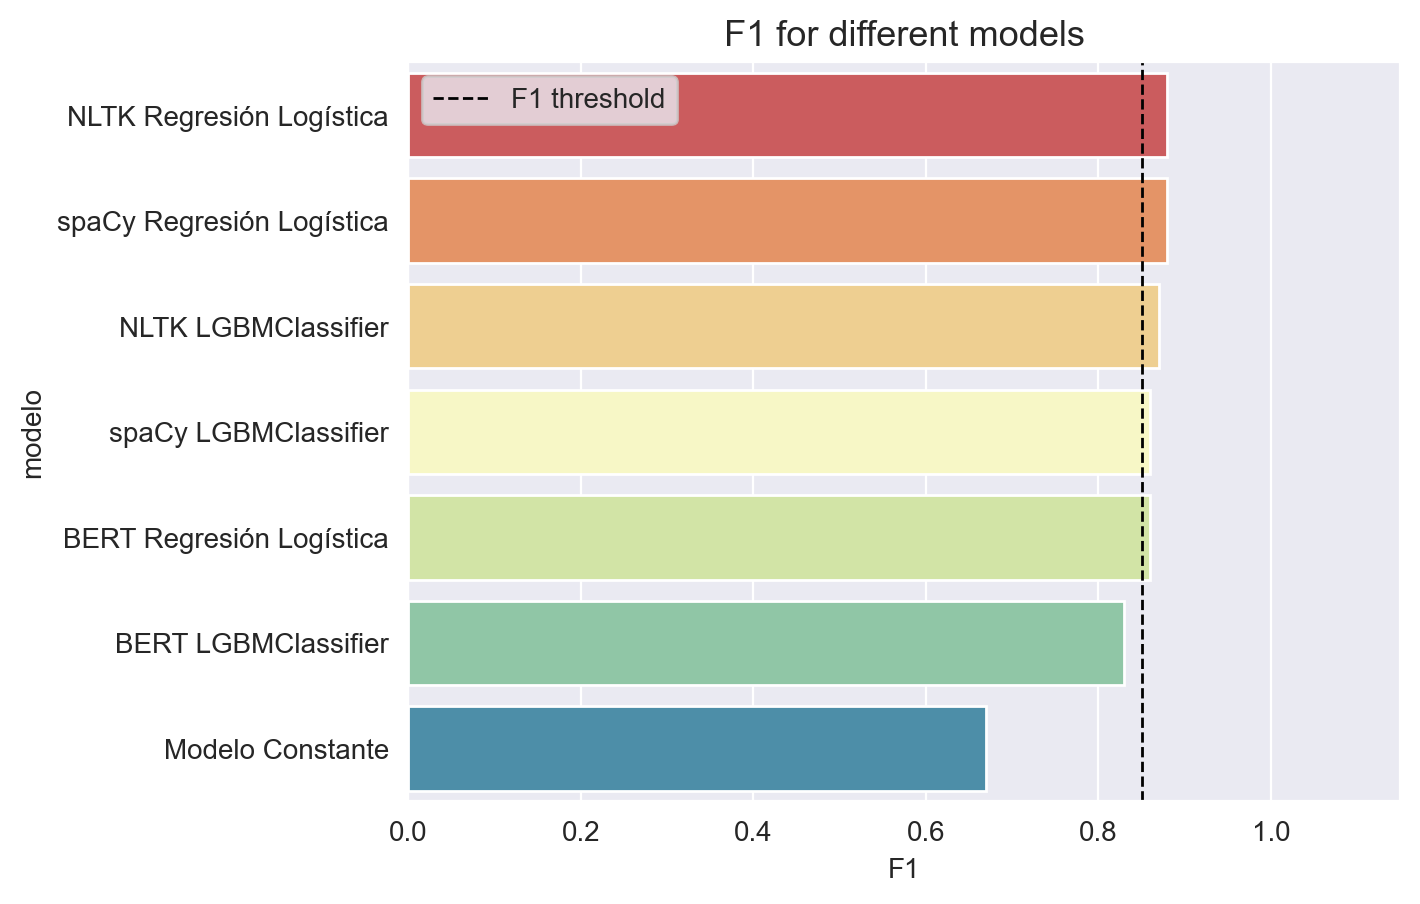

In [118]:
# plot a bar graph
sns.barplot(x='F1', y='modelo', data=models_table, palette=("Spectral"))
plt.axvline(x=0.85, color='black', ls='--', lw=1, label='F1 threshold')
plt.xlim(0, 1.15)
plt.title('F1 for different models', fontsize=13)
plt.legend()
plt.show()

Logistic regression models preprocessed with NLTK and spaCy achieved the highest F1 score: 0.88. This allows us to affirm that the type of preprocessing does not influence the quality of the model, both NLTK and spaCy can be used without affecting the precision and recall of the model. However, it must be considered that spaCy requires a longer time to preprocess text compared to NLTK.

Although the logistic regression models were the ones that reached the highest F1, it should be said that they presented a greater overfit and their performance decreased at higher F1 thresholds. The gradient boosting models instead, maintained their precision and recall even at thresholds of 0.80, which allows us to conclude that the LGBMClassifier models have a higher level of learning than the regression models.

The preprocessing with BERT was the one that produced the lowest F1, so the logistic regression model only reached a value of 0.86 and the LGBMClassifier model 0.83.

## Conclusions <a id='8'></a>

We started our project with the aim of developing a system for filtering and categorizing movie reviews. The goal was to train a model to detect negative reviews automatically. 

IMDb (Internet Movie Database) provided us with a dataframe with polarity legends to help us training a model to classify positive and negative reviews.

We preprocessed the dataframe, finding only 2 absent values and thus deleting the two respective lines. The number of reviews tends to increase as the years go by, with the highest peak in 2006. This would be related to the increase in the number of movies released which have increased in recent years and a resulting greater number of users who publish their opinions about cinema. There is also a greater number of reviews per movie over time. 

Most movies have few reviews, and few movies have more than 10 reviews. However, a group of films were registered that received up to 30 reviews. Regarding the rating received by the different movies, we observed a greater number of films with ratings between 1 to 4, and between 7 to 10. There were no films with ratings of 5 or 6, which can be attributed to the fact that people prefer to rate a movie as good or bad, but not place a score in between.

Texts that were in the 'review' column were normalized, removing extra punctuation marks, digits or spaces. Later, the training and test data set was divided in a 50:50 ratio, the 'pos' columns was set as the target.

A Natural language preprocessing was performed using spaCy, NLTK and BERT tools. For spaCy and NLTK, the texts were tokenized and lemmatized, and after converted into TF-IDF vectors. In the case of BERT, a function was built to get word inserts, which was executed in a GPU environment to reduce execution time.

Logistic regression and gradient boosting models were trained with the three preprocessing methods, obtaining a total of six machine learning models for text.

spaCy and NLTK were the ones that registered the highest score of 0.88. We have to remind that the preprocessing that we ran for BERT was not thorough because it could take too much time. So, our judgment is not really complete.

The difficulty in understanding the general context of a review was found in all models especially when trying to recognize a review with a positive sentiment.